# Correlated Truncation Errors in Effective Field Theory: The code behind the manuscript

This notebook provides the code to reproduce all of the plots from Melendez et al. (2019).
Notebook written by Jordan Melendez.
Commentary by Daniel Phillips and Dick Furnstahl, June 2019.


*Note*: Since publication we have switched the `pivoted_cholesky` function from an underlying GSL to a LAPACK routine.
Their output is generally identical but the exact results can differ very slightly depending on fine details of the input matrix.
Thus some of the PC plots may not be identical to their published versions, but the overall conclusions remain unchanged. (Currently only Fig. 7(c) has changed.)

In [1]:
import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.interpolate as interpolate
import os
import h5py
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import math
import urllib
import tables
import colorsys
import ipywidgets as widgets
from IPython.display import display
import warnings

%matplotlib inline

In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# plotting parameters
# See: https://ianstormtaylor.com/design-tip-never-use-black/
# softblack = '#262626'
softblack = 'k'  # Looks better when printed on tex file
gray = '0.7'
# list(mpl.rcParams['axes.prop_cycle'])
mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['axes.edgecolor'] = softblack
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = softblack
mpl.rcParams['axes.linewidth']

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.color'] = softblack
mpl.rcParams['ytick.color'] = softblack
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

text_bbox = dict(boxstyle='round', fc=(1, 1, 1, 0.6), ec=softblack, lw=0.8)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='pdf')

edgewidth = 0.6

In [3]:
def scale_lightness(rgb, scale_l):
    """
    Scales the lightness of a color. Takes in a color defined in RGB, converts to HLS, lightens
    by a factor, and then converts back to RGB.
    """
    # converts rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulates h, l, s values and returns as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

class GPHyperparameters:
    def __init__(self, ls, sd_gp, center, ref, ratio, nugget, seed, df, disp, 
                 scale, sd_fixed = None):
        """
        Class for the hyperparameters of a Gaussian process.
        """
        self.ls = ls
        self.sd_gp = sd_gp
        self.sd_fixed = sd_fixed
        self.center = center
        self.ref = ref
        self.ratio = ratio
        self.nugget = nugget
        self.seed = seed
        self.df = df
        self.disp = disp
        self.scale = scale

class order_info:
    def __init__(self, n_orders, n_final_order):
        """
        Class for information about the orders of calculation (the highest order of interest, the 
        final order for summing the "true" value, and arrays of the integers from 0 to these numbers)
        """
        self.n_orders = n_orders
        self.n_final_order = n_final_order
        self.orders_array = np.arange(0, self.n_orders)
        self.orders_all_array = np.arange(0, self.n_final_order + 1)

def regular_train_test_split(x, dx_train, dx_test, offset_train = 0, offset_test = 0, \
                                 xmin = None, xmax = None):
    """
    Sets the mask for the x-values for training and testing the Gaussian process.
    """
    train_mask = np.array([(i - offset_train) % dx_train == 0 for i in range(len(x))])
    test_mask = np.array([(i - offset_test) % dx_test == 0 for i in range(len(x))])
    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)
    train_mask = train_mask & (x >= xmin) & (x <= xmax)
    test_mask = test_mask  & (x >= xmin) & (x <= xmax) & (~ train_mask)
    return train_mask, test_mask

def find_nearest(array, value):
    """
    Finds the value in array closest to value and returns that entry.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def mask_mapper(array_from, array_to, mask_from):
    """
    Converts from one mask to another by mapping the entries of the first to the nearest-in-
    value entries in the second.
    """
    mask_array = [( np.argwhere(array_to == find_nearest(array_to, i)) ) for i in array_from[mask_from]]
    mask = np.zeros(len(array_from))
    for i in range(len(mask_array)):
        mask[mask_array[i]] = 1
    return np.array(mask.astype(int), dtype = bool)

def offset_xlabel(ax):
    """
    Sets the offset for the x-axis label.
    """
    ax.set_xticks([0])
    ax.set_xticklabels(labels=[0], fontdict=dict(color='w'))
    ax.tick_params(axis='x', length=0)
    return ax

class PosteriorBounds:
    def __init__(self, x_lower, x_upper, x_n, y_lower, y_upper, y_n):
        """
        Class for the boundaries of the 2D posterior PDF plot and the mesh on which it is plotted.
        """
        self.x_vals = np.linspace(x_lower, x_upper, x_n)
        self.y_vals = np.linspace(y_lower, y_upper, y_n)

def joint_plot(ratio=1, height=3):
    """
    Taken from Seaborn JointGrid
    """
    fig = plt.figure(figsize=(height, height))
    gsp = plt.GridSpec(ratio+1, ratio+1)

    ax_joint = fig.add_subplot(gsp[1:, :-1])
    ax_marg_x = fig.add_subplot(gsp[0, :-1], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gsp[1:, -1], sharey=ax_joint)

    # Turn off tick visibility for the measure axis on the marginal plots
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Turn off the ticks on the density axis for the marginal plots
    plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_marg_x.yaxis.grid(False)
    ax_marg_y.xaxis.grid(False)

    # Make the grid look nice
    from seaborn import utils
    # utils.despine(fig)
    utils.despine(ax=ax_marg_x, left=True)
    utils.despine(ax=ax_marg_y, bottom=True)
    fig.tight_layout(h_pad=0, w_pad=0)
    
    ax_marg_y.tick_params(axis='y', which='major', direction='out')
    ax_marg_x.tick_params(axis='x', which='major', direction='out')
    ax_marg_y.tick_params(axis='y', which='minor', direction='out')
    ax_marg_x.tick_params(axis='x', which='minor', direction='out')
    ax_marg_y.margins(x=0.1, y=0.)

    fig.subplots_adjust(hspace=0, wspace=0)
    
    return fig, ax_joint, ax_marg_x, ax_marg_y

class GSUMobj:
    def __init__(self, gphyperparameters, orderinfo, x, fullyrandomcolors = False, \
                 color_seed = None, constrained = False, x_power = 1):
        """
        Class for everything involving Jordan Melendez's GSUM library.
        gphyperparameters (GPHyperparameters) : parameters for fitted Gaussian process
        orderinfo (order_info) : information on the calculated and plotted orders
        x (float array) : x-coordinate mesh over which the GP is calculated, plotted, and fitted
        fullyrandomcolors (boolean) : are all the colors randomly generated?
        color_seed : value of the seed from which the colors are randomly generated
        constrained (bool) : is the GP fitting process constrained?
        x_power : power by which the x-coordinate is scaled (to test stationarity)
        """
        # reads the hyperparameters to the class
        self.hyp = gphyperparameters
        self.ls = self.hyp.ls
        self.sd_gp = self.hyp.sd_gp
        self.sd_fixed = self.hyp.sd_fixed
        self.center = self.hyp.center
        self.ref = self.hyp.ref
        self.ratio = self.hyp.ratio
        self.nugget = self.hyp.nugget
        self.seed = self.hyp.seed
        self.df = self.hyp.df
        self.disp = self.hyp.disp
        self.scale = self.hyp.scale
        
        # creates a kernel that defines the Gaussian process (GP)
#         self.kernel = RBF(length_scale = self.ls, length_scale_bounds = 'fixed') + \
#                 WhiteKernel(noise_level = self.nugget, noise_level_bounds= 'fixed')
        self.kernel = RBF(length_scale = self.ls, 
                          length_scale_bounds = (self.ls * 0.25, self.ls * 4)) + \
                WhiteKernel(noise_level = self.nugget, noise_level_bounds= 'fixed')

        # reads the order information to the class
        self.orderinfo = orderinfo
        self.n_orders = self.orderinfo.n_orders
        self.n_final_order = self.orderinfo.n_final_order
        self.orders_array = self.orderinfo.orders_array
        self.orders_all_array = self.orderinfo.orders_all_array
        
        # reads whether the colors will be fully randomly chosen or not and what seed will be 
        # used to generate the random ones
        self.fullyrandomcolors = fullyrandomcolors
        self.color_seed = color_seed
        self.color_randomstate = np.random.RandomState(self.color_seed)
        
        if self.fullyrandomcolors:
            # creates an array of random colors
            self.colors = []
            for i in range(0, self.n_final_order + 1):
                self.colors.append(self.color_randomstate.rand(3,))
            self.light_colors = [scale_lightness(color[:3], 1.5) for color in self.colors]
        else:
            # sets the arrays for the colors and the light colors, keeping Jordan Melendez's 
            # scheme for the first five orders and randomizing the colors for higher orders
            cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']]
            self.colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]
            for i in range(len(self.colors), self.n_final_order + 1):
                self.colors.append(self.color_randomstate.rand(3,))
            self.light_colors = [scale_lightness(color[:3], 1.5) for color in self.colors]
        
        # takes in the array of x-values over which the kernel generates the toy curves
        self.x_underlying = x
        self.X_underlying = self.x_underlying[:, None]
        
        # scales the x-axis by some factor, with the resulting x and X arrays being used for all
        # plotting and fitting
        if x_power == 1:
            self.x = self.x_underlying
            self.X = self.X_underlying
        else:
            self.x = (self.x_underlying)**(x_power)
            self.X = self.x[:, None]
        
        # is the GP constrained? The default answer is No
        self.constrained = constrained
        
        # creates the masks for training and testing the GPs
        self.x_train_mask, self.x_valid_mask = regular_train_test_split(self.x_underlying, \
                                dx_train = 24, dx_test = 6, offset_train = 1, offset_test = 1)
        
        # creates the masks for training and testing the GPs, taking into account any scaling 
        # power for the x-coordinate
        self.x_train_mask, self.x_valid_mask = \
                            mask_mapper(self.x_underlying, self.x, self.x_train_mask), \
                            mask_mapper(self.x_underlying, self.x, self.x_valid_mask)
        
        if not constrained:
            # for the given hyperparameters, orders, and x-variable, generates the data to all 
            # orders and extracts the coefficient curves at all orders
            self.gp = gm.ConjugateGaussianProcess(kernel = self.kernel, 
                        center = self.center, df = self.df, disp = self.disp, 
                        scale = self.scale, nugget = 0, sd = self.sd_fixed)
            self.coeffs_all = - self.gp.sample_y(self.X_underlying, 
                                                 n_samples = self.n_final_order + 1, 
                                                 random_state = self.seed)
            self.data_all = gm.partials(self.coeffs_all, self.ratio, ref = self.ref, 
                                        orders = self.orders_all_array)
            self.diffs_all = np.array([self.data_all[:, 0], *np.diff(self.data_all, axis=1).T]).T
            self.data_true = self.data_all[:, -1]
            
            self.coeffs = self.coeffs_all[:, :self.n_orders]
            self.data = self.data_all[:, :self.n_orders]
            self.diffs = self.diffs_all[:, :self.n_orders]
            
        else:
            # given constraints, extracts the coefficient curves at all orders
            self.gp_constrained = gm.ConjugateGaussianProcess(kernel = self.kernel, 
                        optimizer = None).fit(np.array([[0], [1]]), np.array([0, 0]))
            self.cn_constrained = self.gp_constrained.sample_y(self.X_underlying, 
                                    n_samples = self.n_orders, random_state = 5)
            self.yn_constrained = gm.partials(self.cn_constrained, ratio = self.ratio)
    
    def PlotCurvesFull(self):
        # plots the data summed to each order, up to the order we are interested in
        fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

        for i, curve in enumerate(self.data.T):
            ax.plot(self.x, curve, label = r'$y_{}$'.format(i), c = self.colors[i])

        ax.text(0.95, 0.95, 'Predictions', ha = 'right', va = 'top',
                transform = ax.transAxes)
        legend = ax.legend(**top_legend_kwargs)
        ax.set_xlabel(r'$x$')
        ax.set_xticks([0, 0.5, 1])
        ax.set_xticks([0.25, 0.75], minor = True)
        ax.set_xticklabels([0, 0.5, 1])
        ax.set_xlim(0, 1)
        fig.tight_layout()
        
    def PlotCurvesDiffs(self):
        # plots the differences between each order and the next, up to the order we are interested
        # in
        with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
#         with plt.rc_context({"text.usetex": True}):
            fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

            ax.axhline(0, lw = 1, ls = '--', c = softblack)
            # For the zeroth-order, only, use the data itself
            ax.plot(self.x, self.data[:, 0], label = r'$y_0$', c = self.colors[0])
            for i in range(1, self.n_orders):
                # Beyond that, use differences
                ax.plot(self.x, self.diffs[:, i], label = r'$\Delta y_{}$'.format(i), c = self.colors[i])

            ax.text(0.95, 0.95, 'Differences', ha='right', va='top',
                       transform=ax.transAxes)

            legend = ax.legend(**top_legend_kwargs)

            # Format
            ax.set_xlabel(r'$x$')
            ax.set_xticks([0, 0.5, 1])
            ax.set_xticks([0.25, 0.75], minor=True)
            ax.set_xticklabels([0, 0.5, 1])
            ax.set_xlim(0, 1)
            fig.tight_layout()
            plt.show()
        
    def PlotCurvesCoeffs(self):
        # plots the coefficient curves for each order we are interested in
        fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

        for i in range(self.n_orders):
            ax.plot(self.x, self.coeffs[:, i], label = r'$c_{}$'.format(i), c = self.colors[i])

        ax.text(0.95, 0.95, 'Coefficients', ha = 'right', va = 'top', transform = ax.transAxes)
        legend = ax.legend(**top_legend_kwargs)
        ax.set_xlabel(r'$x$')
        ax.set_xticks([0, 0.5, 1])
        ax.set_xticks([0.25, 0.75], minor = True)
        ax.set_xticklabels([0, 0.5, 1])
        ax.set_xlim(0, 1)
        fig.tight_layout()
    
    def PlotPointwiseVariance(self, mask):
        # plots the variance for each order we're interested in at each of a given set of points 
        # (the "mask") and compares to the expected variance
        fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

        for i, c in enumerate(self.coeffs.T):
            ax.plot(self.x, c, color = self.colors[i], zorder = 0)
            ax.plot(self.x[mask], c[mask], ls = '', marker = 'o', color = self.colors[i])

        # Indicate the pointwise errors  
        for i, xi in enumerate(self.x[mask]):
            # Fit a Gaussian to the orders at this x_i
            sd_fit = stats.norm.fit(self.coeffs[mask][i], floc = 0)[1]
            # Draw a vertical arrow showing mean +/- sd
            ax.annotate(
                "", xy = (xi-0.035, sd_fit), xytext = (xi-0.035, -sd_fit), zorder = 1,
                arrowprops = dict(arrowstyle = "<->", capstyle = 'projecting', lw = 1, \
                                  color = softblack),)
            ax.text(xi-0.07, 0.65, r'$\bar c_{}$'.format(i), horizontalalignment = 'center',
                    verticalalignment = 'center', zorder = 1)    

        # Draw length scale
        ax.annotate("", xy = (self.x[mask][2], 2 * self.scale), xytext=(self.x[mask][2] + self.ls, 2 * self.scale),
                    arrowprops = dict(arrowstyle = "<->", capstyle = 'projecting', lw = 1,
                                    color = softblack), zorder = 1)
        ax.text(self.x[mask][2] + self.ls / 2, 1.79 * self.scale, r'$\ell$', horizontalalignment = 'center',
                    verticalalignment = 'center', zorder = 1)

        # Format plot
        ax.axhline(0, 0, 1, c = softblack, lw = 1, zorder = -1)
        ax.axhline(1, 0, 1, c = gray, lw = 1, zorder = -1)
        ax.axhline(-1, 0, 1, c = gray, lw = 1, zorder = -1)
        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([r'$-\bar c$', r'$\mu$', r'$\bar c$'])
        ax.tick_params(length = 0, axis = 'y')
        ax.set_xlabel(r'$x$')
        ax.set_xticks([0, 0.5, 1])
        ax.set_xticks([0.25, 0.75], minor = True)
        ax.set_xticklabels([0, 0.5, 1])

        fig.tight_layout()
        
    def PlotPointwiseFit(self, mask, expensive = True, constrained = False):
        # plots sums of data curves up to each order we're interested in. If the system is 
        # inexpensive, we plot the full sum for each x-value; if the system is expensive, we 
        # plot the full sum of the curves when fit a subset of x-values
        
        # By setting disp=0 and df=inf, no updating of hyperparameters occurs
        # The priors become Dirac delta functions at mu=center and cbar=scale
        # But this assumption could be relaxed, if desired
        trunc_gp = gm.TruncationGP(kernel = self.kernel, ref = self.ref, ratio = self.ratio, \
                                   disp = 0, df = self.df, scale = 1, optimizer = None)
        # Still only fit on a subset of all data to update mu and cbar!
        # We must beware of numerical issues of using data that are "too close"
        trunc_gp.fit(self.X[mask], self.data[mask], orders = self.orders_array)

        fig, axes = plt.subplots(math.ceil(n_orders / 2), 2, sharex = True, sharey = True, \
                                 figsize = (5, 8))
        
        for i, n in enumerate(self.orders_array):
            if expensive:
                # Only get the uncertainty due to truncation (kind='trunc')
                pred_exp, std_trunc_exp = trunc_gp.predict(self.X, order = n, \
                                                               return_std = True)

                for j in range(i, self.n_orders):
                    ax = axes.ravel()[j]
                    ax.plot(self.x, pred_exp, zorder = i-5, c = self.colors[i])
                    ax.plot(self.x[mask], self.data[mask, i], ls = '', c = self.colors[i], \
                            marker = 'o', zorder = i-5)
                    ax.fill_between(self.x, pred_exp + 2 * std_trunc_exp, \
                                    pred_exp - 2 * std_trunc_exp, zorder = i-5, \
                                    facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                                    lw = edgewidth)
                ax = axes.ravel()[i]
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylim(-15, 37)
            else:
                # Only get the uncertainty due to truncation (kind='trunc')
                _, std_trunc = trunc_gp.predict(self.X, order = n, return_std = True, kind = 'trunc')

                for j in range(i, self.n_orders):
                    ax = axes.ravel()[j]
                    ax.plot(self.x, self.data[:, i], zorder = i-5, c = self.colors[i])
                    ax.fill_between(self.x, self.data[:, i] + 2 * std_trunc, \
                                    self.data[:, i] - 2 * std_trunc, zorder = i-5, \
                                    facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                                    lw = edgewidth)
                ax = axes.ravel()[i]
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylim(-15, 37)
                
        fig.tight_layout(h_pad=0.3, w_pad=0.3)
        
    def PlotCurvesConstrained(self, constrained):
        # plots sums of data curves up to each order we're interested in, subject to some 
        # constraint
        if constrained:
            trunc_gp_sym = gm.TruncationGP(kernel = self.kernel, ref=1, ratio = self.ratio, \
                            disp = 0, df = self.df, scale = 1, optimizer = None)
            # fits GP given constraints
            trunc_gp_sym.fit(self.X[::10], self.yn_constrained[::10], orders = self.orders_array, \
                             dX = np.array([[0], [1]]), dy = np.array([0, 0]))

            fig, axes = plt.subplots( math.ceil(self.n_orders / 2), 2, sharex = True, \
                                     sharey = True, figsize = (5, 8) )
            for i, n in enumerate(self.orders_array):
                # Again, only consider the truncation errors for this plot
                _, std_sym = trunc_gp_sym.predict(self.X, order = n, return_std = True, \
                                    kind = 'trunc')

                for j in range(i, self.n_orders):
                    ax = axes.ravel()[j]
                    ax.plot(self.x, self.yn_constrained[:, i], zorder = i-5, c = self.colors[i])
                    ax.fill_between(self.x, self.yn_constrained[:, i] + 2 * std_sym, \
                                    self.yn_constrained[:, i] - 2 * std_sym, zorder = i-5, \
                                    facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                                    lw = edgewidth)
                ax = axes.ravel()[i]
                ax.axhline(0, 0, 1, ls = '--', lw = 0.5, c = softblack, zorder = 0)
                ax.set_xticks([])
                ax.set_yticks([])

            fig.tight_layout(h_pad=0.3, w_pad=0.3);
        else:
            return 0
    
    def PlotGPCurvesFit(self):
        # fits the coefficient curves for the orders we're interested in to a GP at training 
        # points, and then plots (with error bars) alongside true curves at each order
        
        # kernel for fit
        self.kernel_fit = RBF(length_scale = self.ls, 
                          length_scale_bounds = (self.ls * 0.25, self.ls * 4)) + \
                WhiteKernel(noise_level = self.nugget, noise_level_bounds= 'fixed')

        # fits to GP and extracts error bars
        self.gp_diagnostic = gm.ConjugateGaussianProcess(kernel = self.kernel_fit, 
                    center = self.center, disp = self.disp, df = self.df, 
                    scale = self.scale, n_restarts_optimizer = 10, random_state = self.seed, 
                    sd = self.sd_fixed)
        self.gp_diagnostic.fit(self.X[self.x_train_mask], self.coeffs[self.x_train_mask])
        self.pred, self.std = self.gp_diagnostic.predict(self.X, return_std = True)
        self.underlying_std = np.sqrt(self.gp_diagnostic.cov_factor_)
        print("The underlying std. dev. is " + str(self.underlying_std))
        
        fig, ax = plt.subplots(figsize = (3.2, 3.2))
        
        for i, n in enumerate(self.orders_array):
            # plots true and predicted coefficient curves, mask points, and error bars
            ax.plot(self.x, self.pred[:, i], c = self.colors[i], zorder = i-5, ls = '--')
            ax.plot(self.x, self.coeffs[:, i], c = self.colors[i], zorder = i-5)
            ax.plot(self.x[self.x_train_mask], self.coeffs[self.x_train_mask, i], \
                    c = self.colors[i], zorder = i-5, ls = '', marker = 'o', \
                    label = r'$c_{}$'.format(n))
            ax.fill_between(self.x, self.pred[:, i] + 2 * self.std, self.pred[:, i] - 2 * self.std, \
                    zorder = i-5, facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                            lw = edgewidth, alpha = 1)
        
        ax.axhline(2 * self.underlying_std, 0, 1, c = gray, zorder = -10, lw = 1)
        ax.axhline(-2 * self.underlying_std, 0, 1, c = gray, zorder = -10, lw = 1)
        ax.axhline(0, 0, 1, c = softblack, zorder = -10, lw = 1)
        ax.set_xticks(self.x[self.x_valid_mask], minor = True)
        ax.set_xlabel(r'$x$')
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
        ax.tick_params(which = 'minor', bottom = True, top = False)
        ax.legend(ncol = 2, borderaxespad = 0.5, borderpad = 0.4)
        fig.tight_layout()
        
    def PlotSingleCurveFit(self, curve_idx, kernel = None, center = None, disp = None, \
                           df = None, scale = None, nugget = None, mask = np.array([True])):
        # for a single order, plots the true coefficient curve and the curve fit to a GP (with
        # error bars) for some mask
        
        # reads in hyperparameters for the kernel, changing them if they are different from the 
        # original
        if kernel == None:
            kernel = self.kernel
        if center == None:
            center = self.center
        if disp == None:
            disp = self.disp
        if df == None:
            df = self.df
        if scale == None:
            scale = self.scale
        if nugget == None:
            nugget = self.nugget
        if all(mask):
            mask = self.x_train_mask
        
        # interpolates between training points
        interpolater = gm.ConjugateGaussianProcess(kernel = kernel, center = center, disp = disp, \
                        df = df, scale = scale, nugget = nugget)
        interpolater.fit(self.X[mask], self.coeffs[mask, [curve_idx]])
        pred_interp, std_interp = interpolater.predict(self.X, return_std = True)
        
        fig, ax = plt.subplots(figsize=(3.5, 3))

        # Interpolating curve
        ax.plot(self.x, self.coeffs[:, [curve_idx]], c = self.colors[curve_idx],
                label = r'$c_{}$ ($\sigma_n = 0$)'.format(curve_idx), zorder = 0)
        ax.plot(self.x, pred_interp, c = self.colors[curve_idx], ls = '--', zorder = 0)
        ax.plot(self.x[mask], self.coeffs[mask, curve_idx], ls = '', marker = 'o', \
                c = self.colors[curve_idx], markersize = 7, zorder = 0)
        ax.fill_between(self.x, pred_interp - 2 * std_interp, pred_interp + 2 * std_interp, \
                        facecolor = self.light_colors[curve_idx],
                        edgecolor = self.colors[curve_idx], lw = edgewidth, zorder = 0)
        
        # Format plot
        ax.set_xticks([0, 0.5, 1])
        ax.set_xticks([0.25, 0.75], minor = True)
        ax.set_xticklabels([0, 0.5, 1])
        ax.set_xlabel(r'$x$')
        ax.legend()
        fig.tight_layout()
        
    def PlotMD(self, plot_type = 'box'):
        # plots the Mahalanobis distance in one of two ways (box-and-whisker or histogram)
        try:
            # kernel for GP fit
            self.kernel_fit = RBF(length_scale = self.ls, 
                          length_scale_bounds = (self.ls * 0.25, self.ls * 4)) + \
                WhiteKernel(noise_level = self.nugget, noise_level_bounds= 'fixed')

            # fits GP and extracts error bars
            self.gp_diagnostic = gm.ConjugateGaussianProcess(kernel = self.kernel_fit, \
                        center = self.center, disp = self.disp, df = self.df, scale = self.scale, \
                        n_restarts_optimizer = 10, random_state = self.seed)
            self.gp_diagnostic.fit(self.X[self.x_train_mask], self.coeffs[self.x_train_mask])
            self.pred, self.std = self.gp_diagnostic.predict(self.X, return_std = True)
            self.underlying_std = np.sqrt(self.gp_diagnostic.cov_factor_)

            # extracts underlying covariance matrix and calculates the diagnostics
            self.mean_underlying = self.gp_diagnostic.mean(self.X[self.x_valid_mask])
            self.cov_underlying = self.gp_diagnostic.cov(self.X[self.x_valid_mask])
            self.gdgn = gm.GraphicalDiagnostic(self.coeffs[self.x_valid_mask], \
                        self.mean_underlying, self.cov_underlying, colors = self.colors,
                        gray = gray, black = softblack)

            # plots the Mahalanobis distance
            if plot_type == 'box':
                fig, ax = plt.subplots(figsize = (1.5, 3.0))
                ax = self.gdgn.md_squared(type = plot_type, trim = False, title = None, \
                    xlabel = r'$\mathrm{D}_{\mathrm{MD}}^2$')
            elif plot_type == 'hist':
                fig, ax = plt.subplots(figsize=(9, 3.2))
                ax = self.gdgn.md_squared(type = plot_type, title = None, \
                    xlabel = r'$\mathrm{D}_{\mathrm{MD}}^2$')
                ax.set_ylim(0, 25)
            else:
                return 0

            offset_xlabel(ax)
    #       fig.tight_layout()
        except:
            print("The Mahalanobis distance could not be calculated at one or more orders.")
    
    def PlotPC(self):
        # plots the pivoted Cholesky decomposition in one of two ways
        
        try:
            # kernel for GP fit
            self.kernel_fit = RBF(length_scale = self.ls, 
                          length_scale_bounds = (self.ls * 0.25, self.ls * 4)) + \
                WhiteKernel(noise_level = self.nugget, noise_level_bounds= 'fixed')

            # fits GP and extracts error bars
            self.gp_diagnostic = gm.ConjugateGaussianProcess(kernel = self.kernel_fit, center = self.center, \
                        disp = self.disp, df = self.df, scale = self.scale, n_restarts_optimizer = 10, 
                        random_state = self.seed)
            self.gp_diagnostic.fit(self.X[self.x_train_mask], self.coeffs[self.x_train_mask])
            self.pred, self.std = self.gp_diagnostic.predict(self.X, return_std = True)
            self.underlying_std = np.sqrt(self.gp_diagnostic.cov_factor_)

            # extracts underlying covariance matrix and calculates the diagnostics
            self.mean_underlying = self.gp_diagnostic.mean(self.X[self.x_valid_mask])
            self.cov_underlying = self.gp_diagnostic.cov(self.X[self.x_valid_mask])
            self.gdgn = gm.GraphicalDiagnostic(self.coeffs[self.x_valid_mask], \
                        self.mean_underlying, self.cov_underlying, colors = self.colors,
                        gray = gray, black = softblack)

            # plots the pivoted Cholesky decomposition
            with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
#             with plt.rc_context({"text.usetex": True}):
                fig, ax = plt.subplots(figsize = (3.2, 3.2))
                self.gdgn.pivoted_cholesky_errors(ax = ax, title = None)
                ax.set_xticks([2, 4, 6, 8, 10, 12])
                ax.set_xticks([1, 3, 5, 7, 9, 11], minor = True)
                ax.set_yticks([-2, -1, 0, 1, 2])
                ax.text(0.04, 0.967, r'$\mathrm{D}_{\mathrm{PC}}$', bbox = text_bbox, \
                        transform = ax.transAxes, va = 'top', ha = 'left')
                fig.tight_layout()
                plt.show()
        except:
            print("The pivoted Cholesky decomposition could not be calculated at one or more orders.")
    
    def PlotTruncations(self):
        # plots the data summed to each order we're interested in
        
        try:
            # kernel for fit
            self.kernel_fit = RBF(length_scale = self.ls, 
                          length_scale_bounds = (self.ls * 0.25, self.ls * 4)) + \
                WhiteKernel(noise_level = self.nugget, noise_level_bounds= 'fixed')
            
            # fits truncation GP to data given a mask
            self.gp_trunc = gm.TruncationGP(kernel = self.kernel_fit, ref = self.ref, \
                        ratio = self.ratio, center = self.center, disp = self.disp, \
                        df = self.df, scale = self.scale)
            self.gp_trunc.fit(self.X[self.x_train_mask], y = self.data[self.x_train_mask], \
                        orders = self.orders_array)

            # extracts truncation error for each x-value
            self.norm_trunc_cov = self.gp_trunc.cov(self.X[self.x_valid_mask], start = 0, end = 0)
            self.norm_residuals = (self.data_true[self.x_valid_mask, None] - \
                                   self.data[self.x_valid_mask]) / \
                    (self.ratio**(self.orders_array+1) / np.sqrt(1 - self.ratio**2))
            self.gr_dgn_trunc = gm.GraphicalDiagnostic(self.norm_residuals, \
                            mean = np.zeros(self.x[self.x_valid_mask].shape[0]), \
                            cov = self.norm_trunc_cov, colors = self.colors, gray = gray, \
                            black = softblack)

            fig, axes = plt.subplots(math.ceil(self.n_orders / 2), 2, sharex = True, sharey = True, \
                figsize = (3.9, 3.2))

            # plots curves with error
            for i, n in enumerate(self.orders_array):
                _, std_trunc = self.gp_trunc.predict(self.X, order = n, return_std = True, \
                                    kind = 'trunc')

                for j in range(i, self.n_orders):
                    ax = axes.ravel()[j]
                    ax.plot(self.x, self.data[:, i], zorder = i-5, c = self.colors[i])
                    ax.fill_between(self.x, self.data[:, i] + 2 * std_trunc, \
                                    self.data[:, i] - 2 * std_trunc, zorder = i-5, \
                                    facecolor = self.light_colors[i], edgecolor = self.colors[i], \
                                    lw = edgewidth)
                ax = axes.ravel()[i]
                ax.plot(self.x, self.data_true, color = softblack, lw = 1, ls = '--')
                ax.set_xticks([0.25, 0.5, 0.75])
                ax.set_xticks(self.x[self.x_valid_mask], minor = True)
                ax.set_xticklabels([0.25, 0.5, 0.75])
                ax.set_yticks([0, 10, 20])
                ax.set_yticks([-10, 0, 10, 20, 30])
                ax.set_ylim(-15, 37)

            axes[1, 0].set_xlabel(r'$x$')
            axes[1, 1].set_xlabel(r'$x$')
            fig.tight_layout(h_pad=0.3, w_pad=0.3)
            
        except:
            print("The truncation error curves could not be calculated at one or more orders.")
    
    def PlotCredibleIntervals(self):
        # plots credible intervals ("weather plot") for each order we're interested in
        
        try:
            # kernel for fit
            self.kernel_fit = RBF(length_scale = self.ls, 
                          length_scale_bounds = (self.ls * 0.25, self.ls * 4)) + \
                WhiteKernel(noise_level = self.nugget, noise_level_bounds= 'fixed')

            # truncation GP
            self.gp_trunc = gm.TruncationGP(kernel = self.kernel_fit, ref = self.ref, \
                        ratio = self.ratio, center = self.center, disp = self.disp, \
                        df = self.df, scale = self.scale)
            self.gp_trunc.fit(self.X[self.x_train_mask], y = self.data[self.x_train_mask], \
                        orders = self.orders_array)

            # extracts truncation error for each x-value
            self.norm_trunc_cov = self.gp_trunc.cov(self.X[self.x_valid_mask], start = 0, end = 0)
            self.norm_residuals = (self.data_true[self.x_valid_mask, None] - \
                                   self.data[self.x_valid_mask]) / \
                    (self.ratio**(self.orders_array+1) / np.sqrt(1 - self.ratio**2))
            self.gr_dgn_trunc = gm.GraphicalDiagnostic(self.norm_residuals, \
                            mean = np.zeros(self.x[self.x_valid_mask].shape[0]), \
                            cov = self.norm_trunc_cov, colors = self.colors, gray = gray, \
                            black = softblack)

            fig, ax = plt.subplots(figsize = (3.4, 3.2))

            # plots the curves
            for i, n in enumerate(self.orders_array):
                norm_residuals_alt = self.data_true[self.x_valid_mask] - \
                                            self.data[self.x_valid_mask][:,i]
                norm_trunc_cov_alt = self.gp_trunc.cov(self.X[self.x_valid_mask], start = n+1)
                gr_dgn_trunc_alt = gm.GraphicalDiagnostic(
                    norm_residuals_alt, mean = np.zeros(self.x[self.x_valid_mask].shape[0]), \
                    cov = norm_trunc_cov_alt, colors = [self.colors[i]], gray = gray, black = softblack)   
                gr_dgn_trunc_alt.credible_interval(
                   np.linspace(1e-5, 1, 100), band_perc = [0.68, 0.95], ax = ax, title = None,
                   xlabel = r'Credible Interval ($100\alpha\%$)', ylabel = r'Empirical Coverage ($\%$)')
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_xticklabels([0, 20, 40, 60, 80, 100])
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_yticklabels([0, 20, 40, 60, 80, 100])
            fig.tight_layout()
        
        except:
            print("The credible intervals could not be calculated at one or more orders.")
        
    def PlotPosteriorPDF(self, posteriorgrid):
        # plots the posterior PDF for the ratio and correlation length of the fit GP
        
#         try:
        # kernel for fit
        self.kernel_fit = RBF(length_scale = self.ls, 
                          length_scale_bounds = (self.ls * 0.25, self.ls * 4)) + \
                WhiteKernel(noise_level = self.nugget, noise_level_bounds= 'fixed')

        # fits the GP at the mask
        self.gp_trunc = gm.TruncationGP(kernel = self.kernel_fit, ref = self.ref, \
                    ratio = self.ratio, center = self.center, disp = self.disp, \
                    df = self.df, scale = self.scale)
        self.gp_trunc.fit(self.X[self.x_train_mask], y = self.data[self.x_train_mask], \
                    orders = self.orders_array)

        # reads the posterior grid points to the class
        self.posteriorgrid = posteriorgrid
        self.ls_vals = self.posteriorgrid.x_vals
        self.ratio_vals = self.posteriorgrid.y_vals

        # Compute the log likelihood for values on this grid. 
        self.ls_ratio_loglike = np.array([[
            self.gp_trunc.log_marginal_likelihood(theta = [ls_,], ratio = ratio_val) \
            for ls_ in np.log(self.ls_vals)]
            for ratio_val in self.ratio_vals])

        # Makes sure that the values don't get too big or too small
        self.ls_ratio_like = np.exp(self.ls_ratio_loglike - np.max(self.ls_ratio_loglike))

        # Now compute the marginal distributions
        self.ratio_like = np.trapz(self.ls_ratio_like, x = self.ls_vals, axis = -1)
        self.ls_like = np.trapz(self.ls_ratio_like, x = self.ratio_vals, axis = 0)

        # Normalize them
        self.ratio_like /= np.trapz(self.ratio_like, x = self.ratio_vals, axis = 0)
        self.ls_like /= np.trapz(self.ls_like, x = self.ls_vals, axis = 0)

        with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
#             with plt.rc_context({"text.usetex": True}):
            cmap_name = 'Blues'
            cmap = mpl.cm.get_cmap(cmap_name)

            # Setup axes
            fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio = 5, height = 3.4)

            # Plot contour
            ax_joint.contour(self.ls_vals, self.ratio_vals, self.ls_ratio_like,
                             levels = [np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                             cmap = cmap_name, vmin = -0.05, vmax = 0.8, zorder = 1)

            # Now plot the marginal distributions
            ax_marg_y.plot(self.ratio_like, self.ratio_vals, c = cmap(0.8), lw = 1)
            ax_marg_y.fill_betweenx(self.ratio_vals, np.zeros_like(self.ratio_like),
                                    self.ratio_like, facecolor = cmap(0.2), lw = 1)
            ax_marg_x.plot(self.ls_vals, self.ls_like, c = cmap(0.8), lw = 1)
            ax_marg_x.fill_between(self.ls_vals, np.zeros_like(self.ls_vals),
                                   self.ls_like, facecolor = cmap(0.2), lw = 1)

            # Formatting
            ax_joint.set_xlabel(r'$\ell$')
            ax_joint.set_ylabel(r'$Q$')
            ax_joint.axvline(self.ls, 0, 1, c = gray, lw = 1, zorder = 0)
            ax_joint.axhline(self.ratio, 0, 1, c = gray, lw = 1, zorder = 0)
            ax_joint.margins(x = 0, y = 0.)
            ax_joint.set_xlim(0.05, 0.35)
            ax_joint.set_xticks([0.1, 0.2, 0.3])
            ax_joint.set_xticks([0.15, 0.25], minor = True)
            ax_joint.set_yticks([0.4, 0.5, 0.6])
            ax_joint.set_yticks([0.35, 0.45, 0.55, 0.65], minor = True)
            ax_marg_x.set_ylim(bottom = 0);
            ax_marg_y.set_xlim(left = 0);
            ax_joint.text(0.95, 0.95, r'pr$(\ell, Q \,|\, \vec{\mathbf{y}}_k)$', ha='right', \
                          va='top', transform = ax_joint.transAxes, bbox = text_bbox)
            plt.show()
#         except:
#             print("The posterior probability distribution could not be calculated.")
        
    def change_order(self, change_order_array, change_ratio_array, change_ls_array, \
                     change_sd_array, seed_array):
        # can create coefficient curves for some order(s) with a different correlation length, 
        # ratio, variance, etc., from the GP from which all other orders were calculated
        
        # reads the information about the changed orders to the class for ease of access
        self.change_order_array = change_order_array
        self.change_ratio_array = change_ratio_array
        self.change_ls_array = change_ls_array
        self.change_sd_array = change_sd_array
        self.seed_array = seed_array
        
        coeffs_all = self.coeffs_all
        
        # calculates the new curve(s) for some seed(s) and swaps them into the array of 
        # coefficients
        for i, order in enumerate(change_order_array):
            kernel_bad = RBF(length_scale=change_ls_array[i], length_scale_bounds='fixed') + \
                            WhiteKernel(noise_level=self.nugget, noise_level_bounds='fixed')
            gp_bad = gm.ConjugateGaussianProcess(kernel=kernel_bad, center=self.center, \
                            df=np.inf, scale=change_sd_array[i], nugget=0)
            coeffs_bad = - gp_bad.sample_y(self.X, n_samples = 1, random_state=seed_array[i])
            coeffs_all[:, order] = coeffs_bad[:, 0]
            
            self.colors[order] = np.array([0, 0, 0])
            self.light_colors[order] = np.array([128 / 255., 128 / 255., 128 / 255.])
        
        # with new coefficients, calculates the data, differences, etc., for all orders
        self.coeffs_all = coeffs_all
        self.data_all = gm.partials(self.coeffs_all, self.ratio, ref=self.ref, \
                                    orders=self.orders_all_array)
        self.diffs_all = np.array([self.data_all[:, 0], *np.diff(self.data_all, axis=1).T]).T
        # Get the "all-orders" curve
        self.data_true = self.data_all[:, -1]
        self.coeffs = self.coeffs_all[:, :self.n_orders]
        self.data = self.data_all[:, :self.n_orders]
        self.diffs = self.diffs_all[:, :self.n_orders]
    
    def print_changed_orders(self):
        # prints out all the information on the orders whose hyperparameters have been changed
        print("Adjusted orders: " + str(self.change_order_array))
        print("Adjusted ratios: " + str(self.change_ratio_array))
        print("Adjusted correlation lengths: " + str(self.change_ls_array))
        print("Adjusted variances: " + str(self.change_sd_array))
        print("Adjusted seeds: " + str(self.seed_array))
        return 0

def Q_approx(p, Q_parametrization, m_pi, Lambda_b, single_expansion = False):
    """
    Returns the dimensionless expansion parameter Q.
    
    Parameters
    ----------
    p (float or array) : momentum (in MeV)
    Q_parametrization (str) : can be "poly", "max", or "sum"
    Lambda_b (float) : value for the cutoff (in MeV)
    """
#     if single_expansion:
#         m_pi = 0
#     else:
#         m_pi = 0.5  # Set to 0 to just return p/Lambda_b
    
    if Q_parametrization == "poly":
        # Interpolate to smooth the transition from m_pi to p with a polynomial
        n = 8
        q = (m_pi**n + p**n) / (m_pi**(n-1) + p**(n-1)) / Lambda_b
        return q
    
    elif Q_parametrization == "max":
        # Transition from m_pi to p with a maximum function
        m_pi_eff = 1/2
        
        try:
            q = [max(P, m_pi_eff) / Lambda_b for P in p]
        except:
            q = max(p, m_pi_eff) / Lambda_b
        return q
    
    elif Q_parametrization == "sum":
        # Transition from m_pi to p with a simple sum
        q = (p + m_pi) / Lambda_b
        return q

In [4]:
def plot_MD_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                   slider_power_value, change_order_array, change_ratio_array, seed_array, \
                   plot_type, color_seed = None):
    """
    Designed simply to take in hyperparamters and order information (including widgets), generate 
    a GSUMobj, change the desired order(s), and plot the Mahalanobis distance.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotMD(plot_type = plot_type)
    except:
        print("The Mahalanobis distance could not be calculated at one or more orders.")

def plot_PC_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                    slider_power_value, change_order_array, change_ratio_array, seed_array, \
                    color_seed = None):
    """
    Designed simply to take in hyperparamters and order information (including widgets), generate 
    a GSUMobj, change the desired order(s), and plot the pivoted Cholesky decomposition.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotPC()
    except:
        print("The pivoted Cholesky decomposition could not be calculated at one or more orders.")

def plot_weather_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                    slider_power_value, change_order_array, change_ratio_array, seed_array, \
                    color_seed = None):
    """
    Designed simply to take in hyperparamters and order information (including widgets), generate 
    a GSUMobj, change the desired order(s), and plot the credible intervals
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotCredibleIntervals()
    except:
        print("The credible intervals could not be calculated at one or more orders.")

def plot_posterior_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                       slider_power_value, change_order_array, change_ratio_array, seed_array, \
                       widgetposteriorbounds, color_seed = None):
    """
    Designed simply to take in hyperparamters and order information (including widgets), generate 
    a GSUMobj, change the desired order(s), and plot the posterior probability distribution 
    function.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotPosteriorPDF(widgetposteriorbounds)
    except:
        print("The posterior probability distribution could not be calculated.")

def plot_diagnostics_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                   slider_power_value, change_order_array, change_ratio_array, seed_array, \
                   widgetposteriorbounds, plot_type = 'box', color_seed = None):
    """
    Designed simply to take in a GP and order information (including the correlation length from a slider 
    widget), change the desired order(s), and plot the Mahalanobis distance, the pivoted 
    Cholesky decomposition, the credible intervals, and the posterior PDF. Also suppresses 
    warnings.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    
    # we don't need to bother with warnings when we run this snippet of code
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        try:
            WidgetGP.PlotMD(plot_type = plot_type)
        except:
            print("The Mahalanobis distance could not be calculated at one or more orders.")
        try:
            WidgetGP.PlotPC()
        except:
            print("The pivoted Cholesky decomposition could not be calculated at one or more orders.")
        try:
            WidgetGP.PlotCredibleIntervals()
        except:
            print("The credible intervals could not be calculated at one or more orders.")
        try:
            WidgetGP.PlotPosteriorPDF(widgetposteriorbounds)
        except:
            print("The posterior probability distribution could not be calculated.")

# Part I: Gaining Intuition with Widgets

In [5]:
x = np.linspace(0, 1, 101) # grid for x-values

n_orders = 10    # Here we examine the case where we have info on some number of non-trivial orders
final_order = 50  # We are going to treat some high order result as the final, converged answer

# creates the order_info object, which contains information on the total number of orders to be 
# calculated and the number of orders to be plotted
OrdersWidget = order_info(n_orders, final_order)
orders_widget = OrdersWidget.orders_array
orders_all_widget = OrdersWidget.orders_all_array

# The true values of the hyperparameters for generating the EFT coefficients
ls = 0.2
sd_gp = 1
sd_fixed = None
center = 0
ref = 10
ratio = 0.5
nugget = 1e-10
seed = None
df = np.inf
disp = 0
scale = 1
WidgetHyper = GPHyperparameters(ls = ls, sd_gp = sd_gp, sd_fixed = sd_fixed, center = center, 
                                ref = ref, ratio = ratio, nugget = nugget, seed = seed, 
                                df = df, disp = disp, scale = scale)

# posterior grid for the widget
WidgetPosteriorBounds = PosteriorBounds(1e-3, 0.5, 100, 0.3, 0.7, 80)

In [6]:
# we will alter the hyperparameters of the third order alone
change_order_array = [3]
change_ratio_array = [ratio]

# the RNG seed for the altered order can be set manually, chosen once for many runs, or 
# chosen randomly for each run
# seed_array = [16]
# seed_array = np.random.randint(0, 2000000, 1)
seed_array = [None]

# sets a seed for the random color-chooser for stability across parameters and diagnostic widgets
# good ones: 62, 75, 81, 82, 90
color_seed_widget = 81

In [7]:
# initializes a slider for the correlation length in terms of the default value
slider_ls = widgets.FloatSlider(
    min = ls * 3/4,
    max = ls * 5/3,
    step = 0.01,
    description = 'Length scale:',
    value = ls, 
    continuous_update = False
)

# initializes a slider for the variance in terms of the default value
slider_sd = widgets.FloatSlider(
    min = scale * 0.3,
    max = scale / 0.3,
    step = 0.01,
    description = 'Variance:',
    value = scale, 
    continuous_update = False
)

# initializes a slider for the polynomial power of x in terms of the default value
slider_power = widgets.RadioButtons(
    options = [0.250, 0.333, 0.500, 1.000, 2.000, 3.000, 4.000],
    value = 1., 
    description = 'x-power:',
    disabled = False, 
    continuous_update = False
)

##### This is a table of the visual signatures in our statistical diagnostics of pathologies at certain orders (namely, different correlation length, different variance, and polynomial scaling). See if you can replicate these results.

| CETERIS PARIBUS | Mahalanobis distance | Pivoted Cholesky decomposition | Credible interval | $Q$-$\ell$ posterior|
| --- | --- | --- | --- | --- |
| Lower one order's correlation length | That order rises a lot | That order is out of bounds for higher index; other orders too, but less so | X | X |
| Raise one order's correlation length | That order falls a lot | Funnel-shaped overall distribution, but with that order hewing closely to the mean | X | X |
| Lower one order's variance | That order falls a little | That order hews closely to the mean | X | X |
| Raise one order's variance | That order rises a little | That order goes out of bounds | X | X |
| $x \rightarrow x^{n}, n > 1$ | Scattered | Harsh funnel | Some lines go out of bounds | Higher $n$ $\rightarrow$ higher predicted correlation length |
| $x \rightarrow x^{\frac{1}{n}}, n > 1$ | Scattered | Harsh funnel | Some lines go out of bounds | X |

#### Plot all diagnostics (manual update)

This cell plots all four statistical diagnostics of interest--the squared Mahalanobis distance, the pivoted Cholesky decomposition, the credible intervals, and the $Q-\ell$ posterior probability distribution function; further explanation for each can be found below. The user must click to generate new figures.

In [8]:
# plotting all the diagnostics without interative_output
interactive_plot_all = widgets.interactive(plot_diagnostics_widget, {'manual': True}, \
                                      slider_ls_value = slider_ls, \
                                      slider_sd_value = slider_sd, \
                                      slider_power_value = slider_power, \
                                      widgethyper = widgets.fixed(WidgetHyper), \
                                      orderswidget = widgets.fixed(OrdersWidget), \
                                      x = widgets.fixed(x), \
                                      change_order_array = widgets.fixed(change_order_array), \
                                      change_ratio_array = widgets.fixed(change_ratio_array), \
                                      seed_array = widgets.fixed(seed_array), \
                                      widgetposteriorbounds = widgets.fixed(WidgetPosteriorBounds), \
                                      color_seed = widgets.fixed(color_seed_widget), \
                                      plot_type = widgets.fixed('box'))
output = interactive_plot_all.children[-1]
interactive_plot_all

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

#### Plot Mahalanobis distance (manual update)

The squared Mahalanobis distance ("MD") is like a $\chi^{2}$ in the presence of correlations, where the correlations are assessed using the covariance matrix of the fitted GP. As with $\chi^{2}$, a high value MD signals a poor fit and a low value a good fit.

You can plot both a box-and-whisker and a histogram version by changing the value of `plot_type` to `'box'` or `'hist'`, respectively.

In [9]:
# using the slider interactively, plots the Mahalanobis distance
interactive_plot_md = widgets.interactive(plot_MD_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          plot_type = widgets.fixed('box'), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_md.children[-1]
interactive_plot_md

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

#### Plot pivoted Cholesky decomposition (manual update)

Now we decompose the Mahalanobis distance into its component pieces by performing a pivoted Cholesky ("PC") decomposition on the covariance matrix. The resulting PC errors are then plotted against index, with large values indicating poor fit as usual. The index can be related to the testing point in question (see Bastos & O'Hagan's seminal article). Telltale signs of pathology in the convergence pattern include an order's errors hewing too close to the mean or falling outside the typical standard deviation, or a funnel-shaped overall distribution.

In [10]:
# using the slider interactively, plots the pivoted Cholesky decomposition
interactive_plot_pc = widgets.interactive(plot_PC_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_pc.children[-1]
interactive_plot_pc

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

#### Plot the credibility intervals, or "weather plot" (manual update)

Weather forecasting services assign percentage probabilities to the likelihood of precipitation, sunlight, wind, and other meteorological phenomena. If the forecaster is maximally statistically rigorous, that predicted likelihood should converge with the frequentist approach to predicting weather, so that, for example, it should rain on 40% of the days when a 40% chance of rain was forecast. Likewise, we should find that our prediction for the value of some observable (a unitless, meaningless toy observable, in this case) should fall within the 10% confidence interval (measured about the mean) 10% of the time, within 20% 20% of the time, within 30% 30% of the time, etc.

Due to the sparseness of our data, however, by comparison to the far more numerous data of a weather forecaster, that ideal $45^{\circ}$ line itself has error bars, and we plot the 68% confidence interval in the dark gray about that line and the 95% confidence interval in light gray. If our assignment of probabilities is rigorous, our predictions should fall within the dark gray about 68% (roughly two thirds) of the time and within the light gray 95% of the time (roughly nineteen out of twenty times). When a particular order of calculation falls outside these bounds too often, that is a sign that the convergence pattern may be pathological.

In [11]:
interactive_plot_weather = widgets.interactive(plot_weather_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_weather.children[-1]
interactive_plot_weather

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

#### Plot the $Q-\ell$ posterior probability distribution function (manual update)

Taking a Bayesian approach, we can define a likelihood probability distribution function ("PDF") that takes the form of a $\chi^{2}$ and a uniform prior PDF; evaluate their product at each point on a two-dimensional grid in the space defined by $Q$, the dimensionless expansion parameter, and $\ell$, the correlation length of the fitted GP; plot the result, with darker areas having higher probability; plot the "true" values that we actually used for our calculations; and compare. Convergence may be pathological when the true value lies too far from an area of high probability.

In [12]:
interactive_plot_posterior = widgets.interactive(plot_posterior_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          widgetposteriorbounds = widgets.fixed(WidgetPosteriorBounds), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_posterior.children[-1]
interactive_plot_posterior

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

#### Plot all diagnostics (automatic update)

This cell plots all four statistical diagnostics of interest--the squared Mahalanobis distance, the pivoted Cholesky decomposition, the credible intervals, and the $Q-\ell$ posterior probability distribution function. Figures generate automatically whenever the values of the widgets are changed.

In [13]:
# Set up the interactive_output widget 
plot_out = widgets.interactive_output(plot_diagnostics_widget, \
                        dict(
                        widgethyper = widgets.fixed(WidgetHyper), \
                        orderswidget = widgets.fixed(OrdersWidget), \
                        x = widgets.fixed(x), \
                        slider_ls_value = slider_ls, \
                        slider_sd_value = slider_sd, \
                        slider_power_value = slider_power, \
                        change_order_array = widgets.fixed(change_order_array), \
                        change_ratio_array = widgets.fixed(change_ratio_array), \
                        seed_array = widgets.fixed(seed_array), \
                        widgetposteriorbounds = widgets.fixed(WidgetPosteriorBounds), \
                        plot_type = widgets.fixed('box'), \
                        color_seed = widgets.fixed(color_seed_widget))
                        )
plot_out.observe(True, names = 'manual')

# plot_out = widgets.interactive_output(plot_diagnostics_widget, \
#                         {'manual': True, \
#                         'widgethyper': widgets.fixed(WidgetHyper), \
#                         'orderswidget': widgets.fixed(OrdersWidget), \
#                         'x': widgets.fixed(x), \
#                         'slider_ls_value': slider_ls, \
#                         'slider_sd_value': slider_sd, \
#                         'slider_power_value': slider_power, \
#                         'change_order_array': widgets.fixed(change_order_array), \
#                         'change_ratio_array': widgets.fixed(change_ratio_array), \
#                         'seed_array': widgets.fixed(seed_array), \
#                         'widgetposteriorbounds': widgets.fixed(WidgetPosteriorBounds), \
#                         'plot_type': widgets.fixed('box'), \
#                         'color_seed': widgets.fixed(color_seed_widget)}
#                         )

# Now do some manual layout, where we can put the plot anywhere using plot_out
vbox1 = widgets.VBox([slider_ls, slider_sd])
hbox1 = widgets.HBox([vbox1, slider_power])

# We'll set up Tabs to organize the controls.  The Tab contents are declared
#  as tab0, tab1, ... (probably should make this a list?) and the overall Tab
#  is called tab (so its children are tab0, tab1, ...).
tab_height = '70px'  # Fixed minimum height for all tabs. Specify another way?
tab0 = widgets.VBox([hbox1], layout=widgets.Layout(min_height=tab_height))
tab = widgets.Tab(children=[tab0])
tab.set_title(0, 'GP Parameters')

# Release the Kraken!
vbox1 = widgets.VBox([tab, plot_out])
display(vbox1)

## Part II: Applying the Model

### Figure 1: Predictions to Coefficients

First we set up our toy data. Each coefficient in the EFT is a sample from a GP, with a squared exponential kernel, and the same correlation length (0.2) and standard deviation (1) at each order. The expansion parameter is 0.5 (quite large). The code below first generates the coefficients, and then creates predictions that are a sum of these order-by-order pieces by following

\begin{align*}
y_k = y_{\mathrm{ref}} \sum_{n=0}^k c_n Q^n
\end{align*}

Note that within the toy model, one is guaranteed to recover the individual realizations of the GP $c_n$ by inverting this relation *if one has chosen the correct expansion parameter*.

The following section can reproduce the figures in the paper "Quantifying Correlated Truncation Errors in Effective Field Theory," which can be found on the arXiv at https://arxiv.org/abs/1904.10581, with the following parameter values:

* `x = np.linspace(0, 1, 100)`

* `n_orders = 4`
* `final_order = 20`

* `ls = 0.2`
* `sd = 1`
* `center = 0`
* `ref = 10`
* `ratio = 0.5`
* `nugget = 1e-10`
* `seed = 3`

* `fullyrandomcolors = False`
* `color_seed = None`
* `constrained = False`
* `x_power = 1`
* And don't change any orders.

In [14]:
x = np.linspace(0, 1, 101).round(decimals = 2) # grid for x-values
print(x)
x_power = 1 # polynomial scaling factor for x-axis

n_orders = 10    # Here we examine the case where we have info on some numer of non-trivial orders
final_order = 20  # We are going to treat some high order result as the final, converged answer

# creates the orders_info object
OrdersBig = order_info(n_orders, final_order)
orders_big = OrdersBig.orders_array
orders_all_big = OrdersBig.orders_all_array

# The true values of the hyperparameters for generating the EFT coefficients
ls = 0.2
sd_gp = 1.0
sd_fixed = None
center = 0
ref = 10
Q_param_mygp = "sum"
mpi_mygp = 0.5
Lambda_b_mygp = 3
ratio = Q_approx(x, Q_param_mygp, mpi_mygp, Lambda_b_mygp)
print(ratio)
nugget = 1e-10
df = 1
disp = 0
scale = 1.0
seed = 73
color_seed = 90
JordanHyper = GPHyperparameters(ls = ls, sd_gp = sd_gp, center = center, sd_fixed = sd_fixed, 
                                ref = ref, ratio = ratio, nugget = nugget, seed = seed, 
                                df = df, disp = disp, scale = scale)

# makes the GSUM object
MyGP = GSUMobj(JordanHyper, OrdersBig, x, x_power = x_power, color_seed = color_seed)
# print(MyGP.coeffs)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
[0.16666667 0.17       0.17333333 0.17666667 0.18       0.18333333
 0.18666667 0.19       0.19333333 0.19666667 0.2        0.20333333
 0.20666667 0.21       0.21333333 0.21666667 0.22       0.22333333
 0.22666667 0.23       0.23333333 0.23666667 0.24       0.24333333
 0.24666667 0.25       0.25333333 0.25666667 0.26       0.26333333
 0.26666667 0.27       0.27333333 0.27666667 0.28       0.28333333
 0.28666667 0.29       0.29333333 0.29666667 0.3        0.30333333
 0.30666667 0.31 

C:\Users\pjmil\anaconda3\lib\site-packages\gsum\models.py:873: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


In [15]:
# # let's throw off some orders and see what happens
# n_orders_spread = 16
# # change_order_array = np.random.randint(0, final_order + 1, n_orders_spread)
# change_order_array = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18])
# print("Adjusted orders: " + str(change_order_array))
# change_ratio_array = np.random.normal(ratio, ratio * 0.4, n_orders_spread)
# # change_ratio_array = np.random.normal(ratio, ratio * 0.2, 1) * np.ones(n_orders_spread)
# print("Adjusted ratios: " + str(change_ratio_array))
# change_ls_array = np.random.normal(ls, ls * 0.2, n_orders_spread)
# # change_ls_array = np.random.normal(ls, ls * 0.2, 1) * np.ones(n_orders_spread)
# # change_ls_array = 0.15 * np.ones(n_orders_spread)
# print("Adjusted correlation lengths: " + str(change_ls_array))
# change_sd_array = np.random.normal(sd, sd * 0.2, n_orders_spread)
# print("Adjusted variances: " + str(change_sd_array))
# seed_array = np.random.randint(0, 2000000, n_orders_spread)
# print("Adjusted seeds: " + str(seed_array))
# MyGP.change_order(change_order_array, change_ratio_array, change_ls_array, change_sd_array, \
#                    seed_array)

## Reproducing Fig. 1(a, b, c)

In [16]:
top_legend_kwargs = dict(
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1, 0.5), ncol=4,
    borderpad=0.37,
    labelspacing=0.,
    handlelength=1.4,
    handletextpad=0.4, borderaxespad=0,
    edgecolor=softblack,
    mode='expand',
    fancybox=False
)

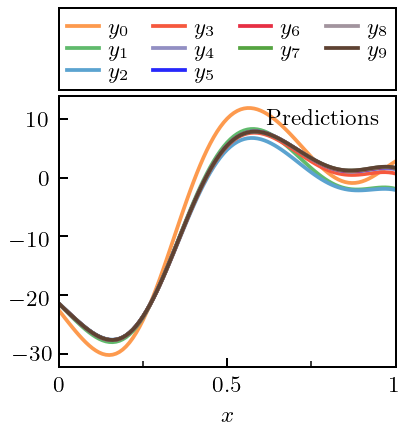

In [17]:
MyGP.PlotCurvesFull()

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


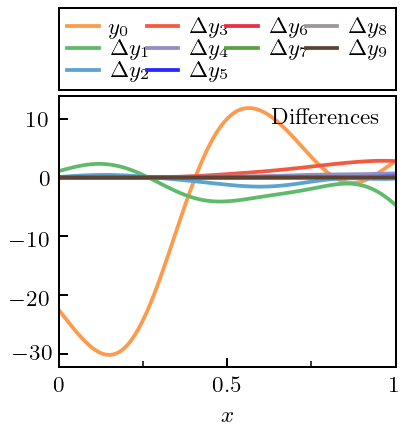

In [18]:
MyGP.PlotCurvesDiffs()

Now show the coefficients $c_n$ (each drawn from one underlying Gaussian Process).
Of course, in a real application, these coefficients would be extracted from the EFT predictions by diving $\Delta y_n$ by $Q^n$.

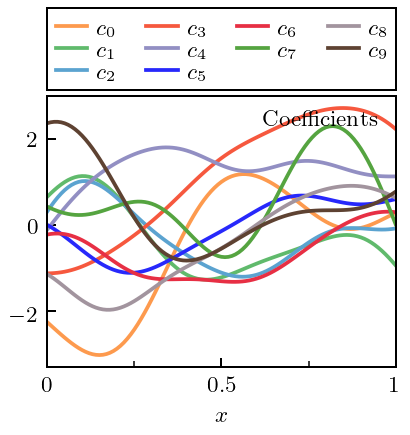

In [19]:
MyGP.PlotCurvesCoeffs()

### Figure 3: Curvewise vs Pointwise Analysis

This next piece of code returns to the curves from Fig. 1(c), and then chooses specific points $x_i$ and computes the standard deviation of the $c_n(x_i)$. It compares that to the standard deviation of the underlying GP.
This "pointwise" approach was employed in Melendez et al. (2017) using a Bayesian formalism. The new GP approach has the advantage of combining data from across the domain (accounting for correlations!) to estimate the variance $\bar c$.

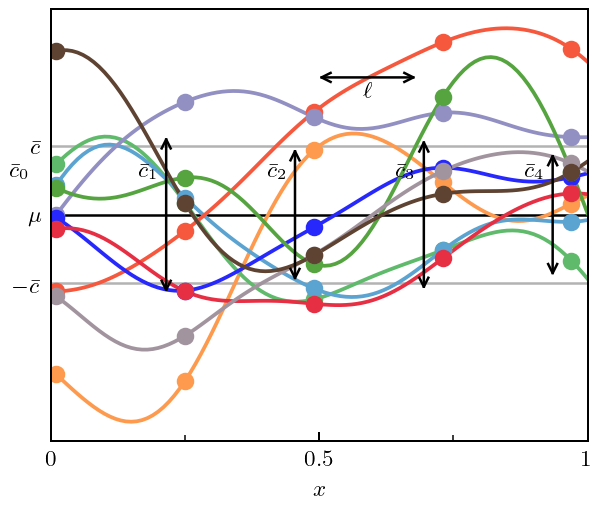

In [20]:
# creates a "mask" of points for comparing expected and true GP curve variance
MyGP.PlotPointwiseVariance(MyGP.x_train_mask)

### Figure 4: Interpolation and Regression with Gaussian Processes

Now we do an example of interpolation, where the training points are exact ($\sigma_n=0$) and regression, where the training points have some errors (we choose $\sigma_n=0.15$).
Training points are shown, with true curves indicated as solid lines, and mean of GP the dashed line. The bands are 95% (2$\sigma$) credible intervals.
For this exercise we choose the underlying curves to be $c_1$ (interpolation) and $c_3$ (regression). 

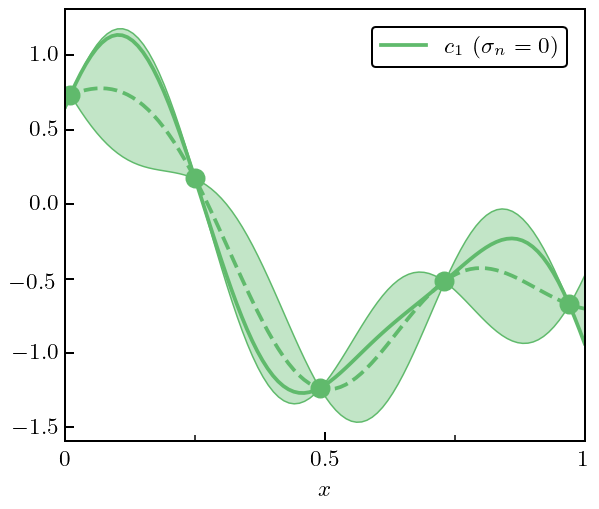

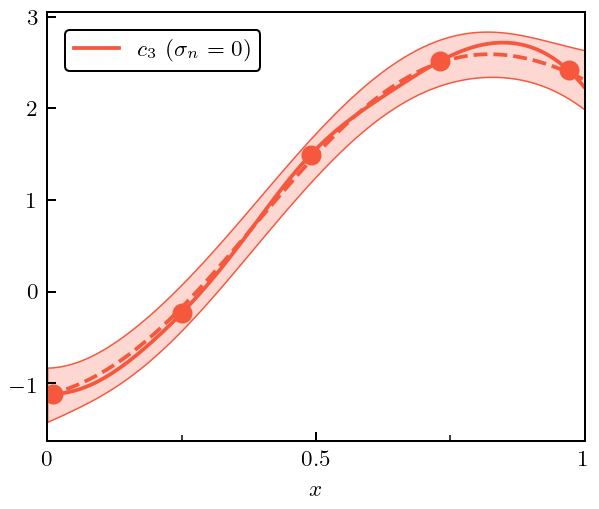

In [21]:
interp_idx = 1  # pick out c_1
MyGP.PlotSingleCurveFit(interp_idx, mask = MyGP.x_train_mask, disp = 0, df = np.inf, scale = sd_fixed, 
                        nugget = 0)

regres_sd = 0.15 # pointwise uncertainty
regres_idx = 3  # pick out c_3
MyGP.PlotSingleCurveFit(regres_idx, mask = MyGP.x_train_mask, disp = 0, df = np.inf, scale = sd_fixed, 
                        nugget = regres_sd**(2))

### Figure 5: GP Priors

Now we plot the priors on our GP. The prior on $\mu$ is a Gaussian, for a given value of $\bar{c}$. For $\bar{c}$ we take a prior that is an inverse $\chi^2$ distribution. The parameters of the $\chi^2$ are:
1. $\nu_0$, the prior number of degrees of freedom;
2. $\tau_0^2$, the prior scale. If $\nu$ becomes large this becomes the MAP value for $\bar{c}$. 

Note that in the opposite limit, where $\nu_0=0$ the prior becomes the scale invariant "Jeffreys prior".

The joint prior pdf is then
$$\mu,\bar{c}^2 \sim N \chi^{-2}(\eta_0,V_0,\nu_0,\tau_0^2)$$

This is mathematically equivalent to a normal-inverse-gamma prior, a fact which we exploit below.

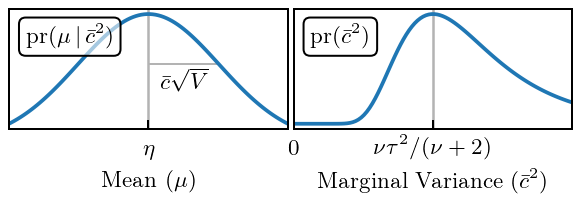

In [22]:
mean = 0
# The uncertainty (std-dev) of mu is Sqrt(V) times cbar,
# the plot is generated for V=1
disp = 1
df = 15
tau2 = (df + 2) / df  # Will put the mode at $\bar c = 1$
gaussian_sd = np.sqrt(tau2*disp)

# Convert to inverse gamma
a = df / 2.
b = df * tau2 / 2.

gaus = stats.norm(mean, gaussian_sd)
igam = stats.invgamma(a, scale=b)
mu_vals = np.linspace(-2.1, 2.1, 100)
cbar_vals = np.linspace(0, 2, 100)

fig, ax = plt.subplots(1, 2, figsize=(3.4, 1.3))

# Plot curves
ax[0].plot(mu_vals, gaus.pdf(mu_vals))
ax[1].plot(cbar_vals, igam.pdf(cbar_vals))

# Add text boxes
ax[0].text(0.06, 0.87, r'pr($\mu \,|\, \bar c^2$)', ha='left', va='top',
           transform=ax[0].transAxes,
           bbox=text_bbox)
ax[1].text(0.06, 0.87, r'pr($\bar c^2$)', ha='left', va='top',
           transform=ax[1].transAxes,
           bbox=text_bbox
          )

# Format plots
line_color = gray
ax[0].set_xlabel(r'Mean ($\mu$)', labelpad=4.5)
# ax[0].set_xlabel(r'Mean ($\mu$)')
ax[1].set_xlabel(r'Marginal Variance ($\bar c^2$)')
ax[0].set_yticks([])
ax[1].set_yticks([])
# plt.xlabel()

ax[0].axvline([mean], 0, 1, c=line_color, zorder=0, lw=1)
# ax[0].set_xticks([-gaussian_sd, mean, gaussian_sd])
# ax[0].set_xticklabels([r'$-\bar c\sqrt{V}$', r'$\eta$', r'$\bar c\sqrt{V}$'], va='bottom')
ax[0].set_xticks([mean])
ax[0].set_xticklabels([r'$\eta$'], va='bottom')
ax[0].tick_params(pad=12)
ax[0].arrow(0, gaus.pdf(gaussian_sd), gaussian_sd, 0, color=line_color, head_width=0., width=0.0001)
# ax[0].text(gaussian_sd+0.25, gaus.pdf(gaussian_sd), r'$\bar c\sqrt{V}$',
#            verticalalignment='center', horizontalalignment='left')
ax[0].text(gaussian_sd/2, gaus.pdf(gaussian_sd)-.02, r'$\bar c\sqrt{V}$',
           verticalalignment='top', horizontalalignment='center')
ax[1].axvline([df * tau2 / (df+2)], 0, 1, c=line_color, zorder=0, lw=1)
ax[1].set_xticks([0, df * tau2 / (df+2)])
ax[1].set_xticklabels([0, r'$\nu\tau^2/(\nu+2)$'], va='bottom')
ax[1].tick_params(pad=12)

fig.tight_layout(w_pad=0)
# fig.savefig('figures/priors')

### Figure 6: Applications

We now consider three different situations where we can use our formalism to compute truncation errors.
1. Straightforward computation in the situation that computing $y_k(x)$ is "cheap", and we can evaluate it at as many points as we wish.
2. The situation where computing $y_k(x)$ is expensive, and we wish to obtain the uncertainty at some $x$, where $y_k(x)$ was not explicitly computed. In this situation we will use our GPs for interpolation too, and then combine the interpolation and truncation error to assess the overall error of our prediction.
3. Truncation errors in the presence of constraints, i.e., a situation where a symmetry guarantees that $\delta y_k(x_0)=0$ at some particular $x_0$.

#### Figure 6(a): Inexpensive Systems

In the figure we show the "EFT prediction" $y_n(x)$ at each order $n$, together with the associated 95% credible interval. The code to do this is actually just two lines, now that we have set up the input data, the mask, and the GP kernel. 

In [23]:
# MyGP.PlotPointwiseFit(MyGP.x_train_mask, expensive = False)

#### Figure 6(b): Expensive Systems

The figures in this case are similar, but now the GP is trained only at the points indicated by the dots.
The total error bands now include both truncation and interpolation error.
Note how the total error on the EFT prediction expands or contracts as one moves away from or towards the points where we have "exact" EFT calculations.

In [24]:
# MyGP.PlotPointwiseFit(MyGP.x_train_mask, expensive = True)

#### Figure 6(c): Constraints

We now consider the case that the observable in question is constrained to be zero at both x=0 and x=1. This means that the EFT should maintain that constraint at all orders, and that the truncation-error model should incorporate that constraint. The truncation classes in `gsum` have two parameters in their `.fit` methods that permit the inclusion of constraints: `dX` and `dy`. Using that feature, things proceed in parallel to Fig. 6(a).

In [25]:
# # This generates data that are constrained as described above
# ConstrainedHyper = GPHyperparameters(ls = 0.25, sd = sd, center = center, ref = ref, ratio = ratio, \
#                                 nugget = 1e-7, seed = seed)

# # different grid of x-values for the constrained GP
# x2 = np.linspace(0, 1, 50)

# MyGPConstrained = GSUMobj(ConstrainedHyper, OrdersBig, x2, constrained = True)

In [26]:
# MyGPConstrained.PlotCurvesConstrained(constrained = True)

## Section III: Diagnostics

#### Figure 7(a): Coefficient curves fit to a subset of points with a Gaussian process

Here we split the data into a "training set" and a "testing set". The training set is indicated by the dots, and gives the data to which the GP used to assess the truncation error is fit. The location of the testing point is indicated by the tick marks on the x-axis. The solid line indicates the mean value of the GP for each EFT coefficient and the bubbles at the 95% DoB interval.

The underlying std. dev. is 1.1136280343890672


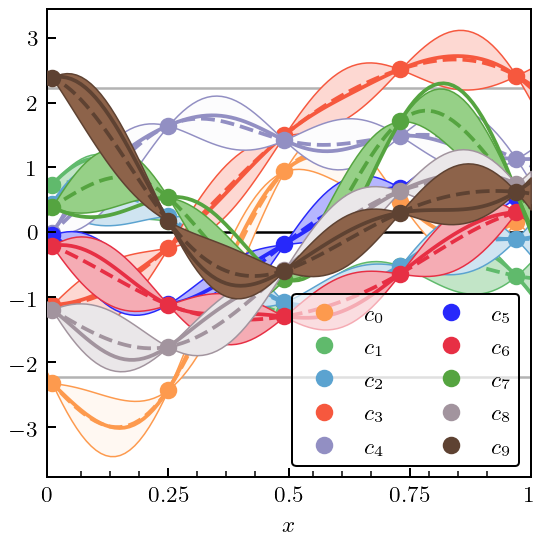

In [27]:
# # creates the same GSUM object as before, but with different hyperparameters
# JordanHyper = GPHyperparameters(ls = ls, 
#                                 sd = sd, 
#                                 center = 0, 
#                                 ref = ref, 
#                                 ratio = ratio, 
#                                 disp = 0, 
#                                 nugget = nugget, 
#                                 seed = seed, 
#                                 df = 1, 
#                                 scale = 1)

# print(ratio)
# MyGP = GSUMobj(JordanHyper, OrdersBig, x, x_power = x_power)
# # MyGP.change_order(change_order_array, change_ratio_array, change_ls_array, change_sd_array, \
# #                    seed_array)
MyGP.PlotGPCurvesFit()

Here are the best guesses for $\bar c$ and $\ell$ after performing the fit

In [28]:
print(r'Std. dev. expected value:', MyGP.underlying_std)

Std. dev. expected value: 1.1136280343890672


In [29]:
print(MyGP.gp_diagnostic.df_)
print(MyGP.gp_diagnostic.scale_)
# print(MyGP.gp_diagnostic.kernel)
print(np.exp(MyGP.gp_diagnostic.kernel_.theta))
print(np.sqrt(MyGP.gp_diagnostic.df_ * MyGP.gp_diagnostic.scale_**2 / (MyGP.gp_diagnostic.df_ + 2)))
print(f'{MyGP.underlying_std:.12f}')
print(MyGP.std)

51
1.0915738102991894
[0.19990639]
1.0707800238292664
1.113628034389
[3.93355467e-02 1.92886006e-05 3.70163368e-02 7.14253958e-02
 1.02959362e-01 1.31374901e-01 1.56457216e-01 1.78023808e-01
 1.95927877e-01 2.10061301e-01 2.20357122e-01 2.26791494e-01
 2.29385029e-01 2.28203514e-01 2.23357963e-01 2.15003984e-01
 2.03340458e-01 1.88607529e-01 1.71083922e-01 1.51083624e-01
 1.28951955e-01 1.05061093e-01 7.98051030e-02 5.35945569e-02
 2.68508077e-02 1.92886006e-05 2.65330238e-02 5.23309389e-02
 7.69901127e-02 1.00126578e-01 1.21381819e-01 1.40428201e-01
 1.56973968e-01 1.70767730e-01 1.81602346e-01 1.89318148e-01
 1.93805432e-01 1.95006188e-01 1.92915017e-01 1.87579223e-01
 1.79098071e-01 1.67621221e-01 1.53346347e-01 1.36515998e-01
 1.17413723e-01 9.63595387e-02 7.37048086e-02 4.98266068e-02
 2.51216683e-02 1.92886042e-05 2.51216683e-02 4.98266068e-02
 7.37048086e-02 9.63595387e-02 1.17413723e-01 1.36515998e-01
 1.53346347e-01 1.67621221e-01 1.79098071e-01 1.87579223e-01
 1.92915017e-01 

In [30]:
# Print out the kernel of the fitted GP
MyGP.gp_diagnostic.kernel_

RBF(length_scale=0.2) + WhiteKernel(noise_level=1e-10)

#### Figure 7(b): Squared Mahalanobis distance

This is like a $\chi^2$ in the presence of correlations.
The correlations are assessed using the covariance matrix of the fitted GP.
Both the box-and-whisker and histogram versions are plotted.

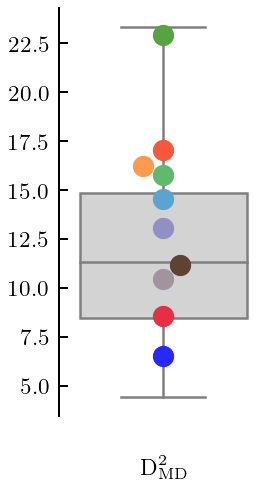

In [31]:
# we print the changed orders and their hyperparameters for ease of interpretation
# MyGP.print_changed_orders()
MyGP.PlotMD(plot_type = 'box')

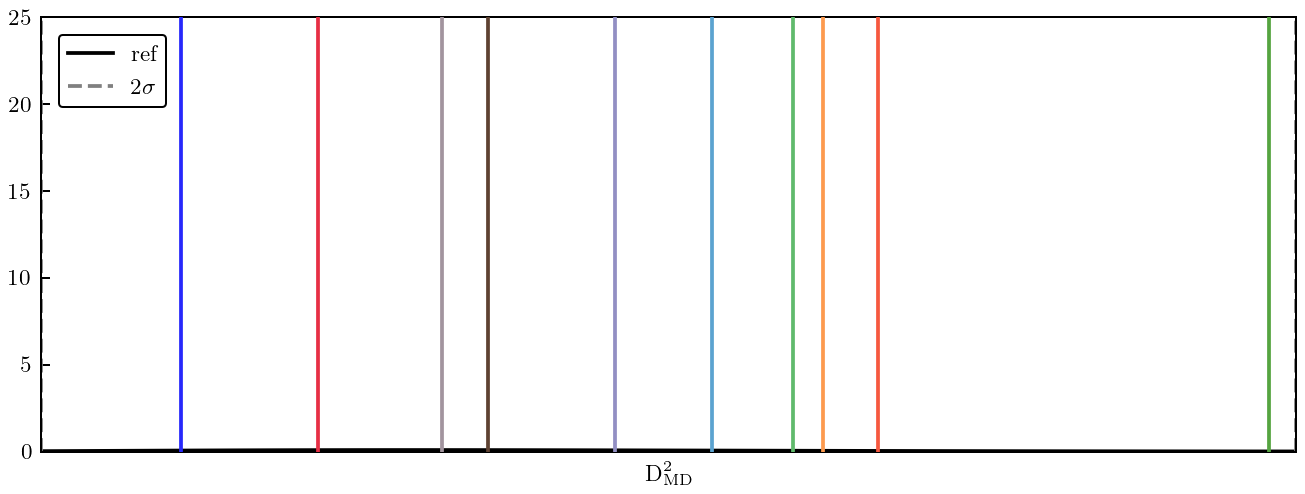

In [32]:
# we print the changed orders and their hyperparameters for ease of interpretation
# MyGP.print_changed_orders()
MyGP.PlotMD(plot_type = 'hist')

#### Figure 7(c): Pivoted Cholesky errors
Now we decompose the Mahalanobis distance into its component pieces, by doing a Pivoted Cholesky decomposition on the covariance matrix. The resulting PC errors are then plotted against index. The index can be related to the testing point in question, see Bastos & O'Hagan's seminal article. Note that `gsum` has the ability to display Pivoted Cholesky (and several other) decompositions of the MD, see third line of code below. 

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


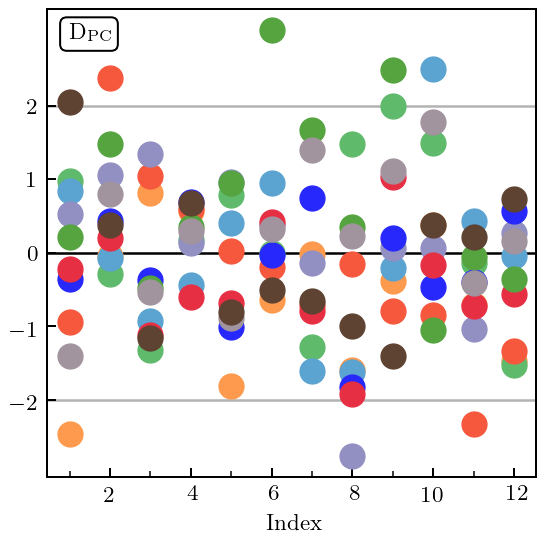

In [33]:
# we print the changed orders and their hyperparameters for ease of interpretation
# MyGP.print_changed_orders()
MyGP.PlotPC()

### Figure 8

Now we compare the truncation errors computed at each order using the GP obtained above with the "true" (summed to order $n=20$) result from the toy EFT (dashed line), see Fig. 8(a). This comparison is done at the validation points indicated by the tick marks on the x-axis and produces the "Credible Interval Diagnostic" plot of Fig. 8(b). Note that `gsum` also has a command to generate this plot.

In [34]:
MyGP.PlotTruncations()

The truncation error curves could not be calculated at one or more orders.


In [35]:
MyGP.PlotCredibleIntervals()

The credible intervals could not be calculated at one or more orders.


In [36]:
# # posterior grid
# JordanPosteriorBounds = PosteriorBounds(1e-3, 0.5, 100, 0.3, 0.7, 80)
# MyGP.PlotPosteriorPDF(JordanPosteriorBounds)
# ratio_map_idx, ls_map_idx = np.unravel_index(np.argmax(MyGP.ls_ratio_like), MyGP.ls_ratio_like.shape)
# print('Best Q:', MyGP.ratio_vals[ratio_map_idx])
# print('Best length scale:', MyGP.ls_vals[ls_map_idx])

In [37]:
def Lb_logprior(Lb):
    """Melendez et al., Eq. (31)"""
#     return np.where((0.01 <= Lb) & (Lb <= 5.00), np.log(1. / Lb), -np.inf)
#     return np.where((0.1 <= Lb) & (Lb <= 10), np.log(1 / Lb), -np.inf)
    return np.where((0.01 <= Lb) & (Lb <= 5), 0, -np.inf)

def mpieff_logprior(mpi, mean = 0.5, sigma = 0.1):
#     return np.where((0.05 <= mpi) & (mpi <= 2.5), np.log(1 / mpi), -np.inf)
    return np.where((0.1 <= mpi) & (mpi <= 1.0), 0, -np.inf)
#     return -0.5 * ((mpi - mean) / sigma)**(2)

def compute_posterior_intervals(model, data, ratios, ref, orders, max_idx, logprior, Lb):
    print("We're about to fit.")
    print("data has shape " + str(np.shape(data[:, :max_idx+1])))
    print("ratios has shape " + str(np.shape(ratios[0, :])))
    print("ratios = " + str(ratios[0, :]))
    print("ref has shape " + str(np.shape(ref)))
    print("ref = " + str(ref))
    print("orders has shape " + str(np.shape(orders[:max_idx + 1])))
    model.fit(data[:, :max_idx+1], ratio=ratios[0, :], ref=ref, orders=orders[:max_idx + 1])
    log_like = np.array([model.log_likelihood(ratio=ratio) for ratio in ratios])
    print(log_like)
    log_like += logprior
    posterior = np.exp(log_like - np.max(log_like))
    posterior /= np.trapz(posterior, x=Lb)  # Normalize

    bounds = np.zeros((2,2))
    for i, p in enumerate([0.68, 0.95]):
        # bounds[i] = gm.hpd_pdf(pdf=posterior, alpha=p, x=Lb, disp=False)
        bounds[i] = gm.hpd_pdf(pdf=posterior, alpha=p, x=Lb)

    median = gm.median_pdf(pdf=posterior, x=Lb)
    return posterior, bounds, median

def draw_summary_statistics(bounds68, bounds95, median, height=0, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(bounds68, [height, height], c='darkgrey', lw=6, solid_capstyle='round')
    ax.plot(bounds95, [height, height], c='darkgrey', lw=2, solid_capstyle='round')
    ax.plot([median], [height], c='white', marker='o', zorder=10, markersize=3)

In [38]:
def PlotLambdaPosteriorUncorr(gsumobj, testing_pts, Q_param, max_idx = None):
    if max_idx is None:
        max_idx = max(gsumobj.orders_array)
        
    Lambda_b_array = np.linspace(0.01, 10, 500)
    print(Lambda_b_array[299])

    # scale invariant: df = 0
    Lb_model = gm.TruncationPointwise(df = 0, excluded = [0])

    ratios_data_Lb = np.array([Q_approx(testing_pts, Q_param, 0.5, Lb) for Lb in Lambda_b_array])
    print("ratios = " + str(ratios_data_Lb[299, :]))
    print("ratios has shape " + str(np.shape(ratios_data_Lb)))
    logprior = Lb_logprior(Lambda_b_array)
    
    Lb_colors = gsumobj.colors[-2:]
        
    # Mask unused data, and compute results
    print("coeffs has shape " + str(np.shape(gsumobj.coeffs)))
    print(gsumobj.coeffs)
    print("orders_all_array = " + str(gsumobj.orders_all_array))
    print("orders_all_array = " + str(gsumobj.orders_array))
    print(np.shape(np.isin(gsumobj.orders_all_array, gsumobj.orders_array)))
    
    print(gsumobj.x)
    print(testing_pts)
    print(np.shape(np.isin(gsumobj.x, testing_pts)))
    print(np.isin(gsumobj.x, testing_pts))
    print(gsumobj.x[np.isin(gsumobj.x, testing_pts)])
    data_Lb = gsumobj.data[np.isin(gsumobj.x, testing_pts), :]
    print("data_Lb has shape " + str(np.shape(data_Lb)))
    print(np.shape(data_Lb[:, 0]))
    data_Lb_nho_result = compute_posterior_intervals(
        Lb_model, data_Lb, ratios_data_Lb, ref = data_Lb[:, 0], 
        orders = gsumobj.orders_array, 
        max_idx = max_idx - 0,
        logprior = logprior, Lb = Lambda_b_array)
    data_Lb_ho_result = compute_posterior_intervals(
        Lb_model, data_Lb, ratios_data_Lb, ref = data_Lb[:, 0], 
        orders = gsumobj.orders_array, 
        max_idx = max_idx + 1,
        logprior = logprior, Lb = Lambda_b_array)

    # Gather the above results
    results = [data_Lb_nho_result, data_Lb_ho_result]

    # Plot each posterior and its summary statistics
    fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
    for i, (posterior, bounds, median) in enumerate(results):
        posterior = posterior / (1.2*np.max(posterior))  # Scale so they're all the same height
        # Make the lines taper off
        Lb_vals = Lambda_b_array[posterior > 1e-2]
        posterior = posterior[posterior > 1e-2]
        # Plot and fill posterior, and add summary statistics
        ax.plot(Lb_vals, posterior-i, c='darkgrey')
        ax.fill_between(Lb_vals, -i, posterior-i, facecolor=Lb_colors[i % 2])
        draw_summary_statistics(*bounds, median, ax=ax, height=-i)

    # Plot formatting
    ax.set_yticks([-0.5, 0.5])
#     ax.set_yticks([-1.1, -3.1], minor=True)
    ax.set_yticklabels([r'HO', r'N$^{-1}$HO'])
#     ax.tick_params(axis='both', which='both', direction='in')
#     ax.tick_params(which='major', length=0)
#     ax.tick_params(which='minor', length=7, right=True)
    ax.set_xlim(0, 6)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xlabel(r'$\Lambda_b$')
    ax.grid(axis='x')
    ax.set_axisbelow(True)
    
    return median, bounds;

5.9959919839679365
ratios = [0.10006684 0.11674465 0.13342246 0.15010027 0.16677807 0.18345588
 0.20013369 0.2168115  0.2334893 ]
ratios has shape (500, 9)
coeffs has shape (101, 10)
[[-2.25372206  0.65456174  0.31060725 ...  0.42748999 -1.14003986
   2.36362467]
 [-2.32719724  0.73363692  0.42899869 ...  0.389829   -1.191966
   2.38513026]
 [-2.40045979  0.80853001  0.53924084 ...  0.35536566 -1.24861433
   2.39615164]
 ...
 [ 0.201255   -0.75501183 -0.09983691 ...  0.4261271   0.70982757
   0.67013457]
 [ 0.2397367  -0.84319843 -0.09157474 ...  0.2240203   0.67122392
   0.72109999]
 [ 0.27579568 -0.9359205  -0.07933448 ...  0.01882715  0.63000663
   0.77474259]]
orders_all_array = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
orders_all_array = [0 1 2 3 4 5 6 7 8 9]
(21,)
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.3

(3.093086172344689,
 array([[2.97296593, 3.17316633],
        [2.87286573, 3.31330661]]))

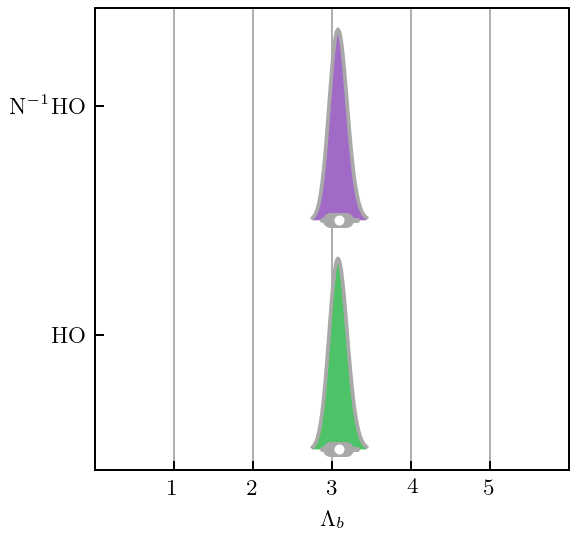

In [39]:
PlotLambdaPosteriorUncorr(MyGP, np.array([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]), "sum")

5.9959919839679365
ratios = [0.10673797 0.1300869  0.15510361 0.17845254 0.20346925 0.22681818]
ratios has shape (500, 6)
coeffs has shape (101, 10)
[[-2.25372206  0.65456174  0.31060725 ...  0.42748999 -1.14003986
   2.36362467]
 [-2.32719724  0.73363692  0.42899869 ...  0.389829   -1.191966
   2.38513026]
 [-2.40045979  0.80853001  0.53924084 ...  0.35536566 -1.24861433
   2.39615164]
 ...
 [ 0.201255   -0.75501183 -0.09983691 ...  0.4261271   0.70982757
   0.67013457]
 [ 0.2397367  -0.84319843 -0.09157474 ...  0.2240203   0.67122392
   0.72109999]
 [ 0.27579568 -0.9359205  -0.07933448 ...  0.01882715  0.63000663
   0.77474259]]
orders_all_array = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
orders_all_array = [0 1 2 3 4 5 6 7 8 9]
(21,)
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0

(3.093086172344689,
 array([[2.95294589, 3.21320641],
        [2.81280561, 3.35334669]]))

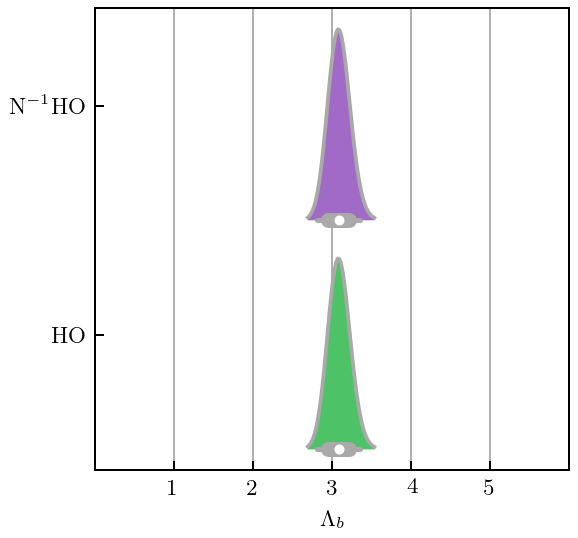

In [40]:
PlotLambdaPosteriorUncorr(MyGP, np.array([0.14, 0.28, 0.43, 0.57, 0.72, 0.86]), "sum")

5.9959919839679365
ratios = [0.12508356 0.16677807 0.20847259]
ratios has shape (500, 3)
coeffs has shape (101, 10)
[[-2.25372206  0.65456174  0.31060725 ...  0.42748999 -1.14003986
   2.36362467]
 [-2.32719724  0.73363692  0.42899869 ...  0.389829   -1.191966
   2.38513026]
 [-2.40045979  0.80853001  0.53924084 ...  0.35536566 -1.24861433
   2.39615164]
 ...
 [ 0.201255   -0.75501183 -0.09983691 ...  0.4261271   0.70982757
   0.67013457]
 [ 0.2397367  -0.84319843 -0.09157474 ...  0.2240203   0.67122392
   0.72109999]
 [ 0.27579568 -0.9359205  -0.07933448 ...  0.01882715  0.63000663
   0.77474259]]
orders_all_array = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
orders_all_array = [0 1 2 3 4 5 6 7 8 9]
(21,)
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51

(3.11310621242485,
 array([[2.89288577, 3.31330661],
        [2.69268537, 3.53352705]]))

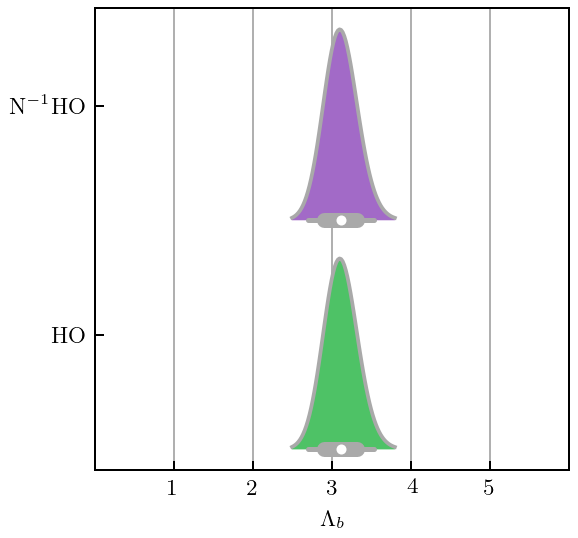

In [41]:
PlotLambdaPosteriorUncorr(MyGP, np.array([0.25, 0.50, 0.75]), "sum")

5.9959919839679365
ratios = [0.08338818 0.0833072  0.08248072 0.08049779 0.08338904 0.09642793
 0.11385456 0.13162551 0.14902812]
ratios has shape (500, 9)
coeffs has shape (101, 10)
[[-2.25372206  0.65456174  0.31060725 ...  0.42748999 -1.14003986
   2.36362467]
 [-2.32719724  0.73363692  0.42899869 ...  0.389829   -1.191966
   2.38513026]
 [-2.40045979  0.80853001  0.53924084 ...  0.35536566 -1.24861433
   2.39615164]
 ...
 [ 0.201255   -0.75501183 -0.09983691 ...  0.4261271   0.70982757
   0.67013457]
 [ 0.2397367  -0.84319843 -0.09157474 ...  0.2240203   0.67122392
   0.72109999]
 [ 0.27579568 -0.9359205  -0.07933448 ...  0.01882715  0.63000663
   0.77474259]]
orders_all_array = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
orders_all_array = [0 1 2 3 4 5 6 7 8 9]
(21,)
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.3

(1.9519438877755513,
 array([[1.87186373, 2.01200401],
        [1.79178357, 2.07206413]]))

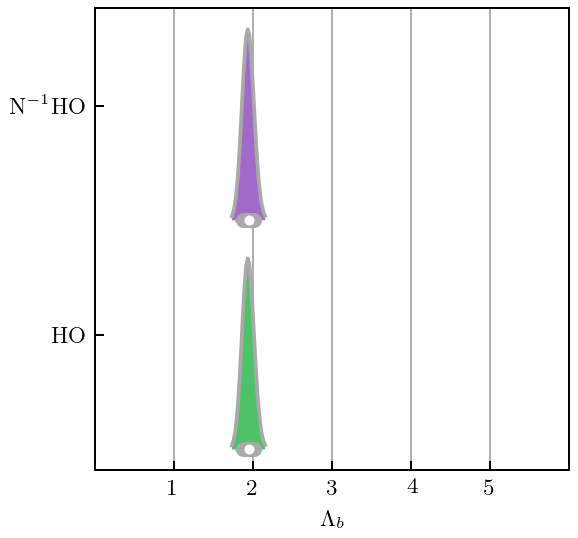

In [42]:
PlotLambdaPosteriorUncorr(MyGP, np.array([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]), "poly")

5.9959919839679365
ratios = [0.08338094 0.0827661  0.08037562 0.0917301  0.11742896 0.14211059]
ratios has shape (500, 6)
coeffs has shape (101, 10)
[[-2.25372206  0.65456174  0.31060725 ...  0.42748999 -1.14003986
   2.36362467]
 [-2.32719724  0.73363692  0.42899869 ...  0.389829   -1.191966
   2.38513026]
 [-2.40045979  0.80853001  0.53924084 ...  0.35536566 -1.24861433
   2.39615164]
 ...
 [ 0.201255   -0.75501183 -0.09983691 ...  0.4261271   0.70982757
   0.67013457]
 [ 0.2397367  -0.84319843 -0.09157474 ...  0.2240203   0.67122392
   0.72109999]
 [ 0.27579568 -0.9359205  -0.07933448 ...  0.01882715  0.63000663
   0.77474259]]
orders_all_array = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
orders_all_array = [0 1 2 3 4 5 6 7 8 9]
(21,)
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0

(1.9319238476953908,
 array([[1.83182365, 1.99198397],
        [1.75174349, 2.09208417]]))

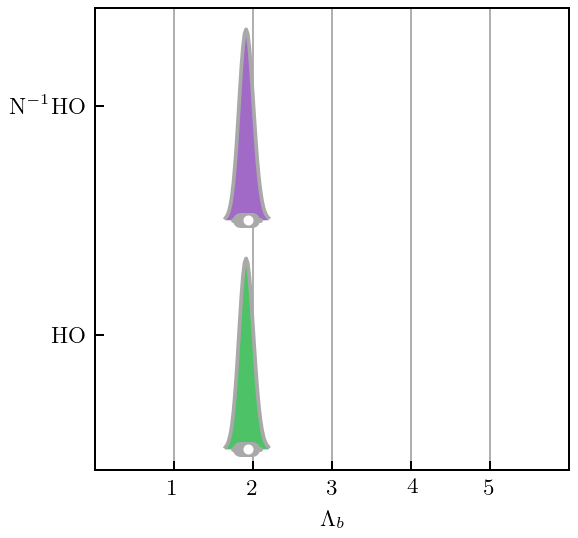

In [43]:
PlotLambdaPosteriorUncorr(MyGP, np.array([0.14, 0.28, 0.43, 0.57, 0.72, 0.86]), "poly")

5.9959919839679365
ratios = [0.08306582 0.08338904 0.1227782 ]
ratios has shape (500, 3)
coeffs has shape (101, 10)
[[-2.25372206  0.65456174  0.31060725 ...  0.42748999 -1.14003986
   2.36362467]
 [-2.32719724  0.73363692  0.42899869 ...  0.389829   -1.191966
   2.38513026]
 [-2.40045979  0.80853001  0.53924084 ...  0.35536566 -1.24861433
   2.39615164]
 ...
 [ 0.201255   -0.75501183 -0.09983691 ...  0.4261271   0.70982757
   0.67013457]
 [ 0.2397367  -0.84319843 -0.09157474 ...  0.2240203   0.67122392
   0.72109999]
 [ 0.27579568 -0.9359205  -0.07933448 ...  0.01882715  0.63000663
   0.77474259]]
orders_all_array = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
orders_all_array = [0 1 2 3 4 5 6 7 8 9]
(21,)
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51

(1.7717635270541083,
 array([[1.65164329, 1.87186373],
        [1.53152305, 1.99198397]]))

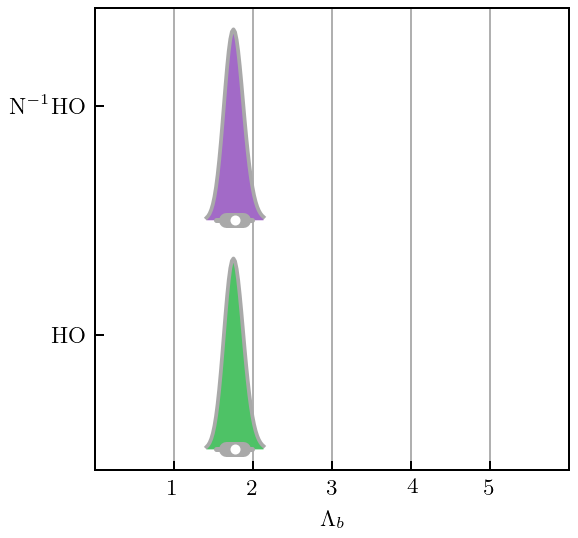

In [44]:
PlotLambdaPosteriorUncorr(MyGP, np.array([0.25, 0.50, 0.75]), "poly")

In [45]:
def PlotLambdaMpiPosteriorCorr(gsumobj, testing_pts, Q_param, max_idx = None, 
        Lambda_b_true = 3, mpi_true = 0.5, whether_plot_joint_Lbls = True, 
        whether_plot_joint_mpils = True, whether_plot_joint_Lbmpi = True, 
        whether_plot_lambda = True, whether_plot_mpi = True):
#     print(Lambda_b_true)
#     def lambda_interp_f_ratio_Lb(x_, lambda_var, Lambda_b):
#         X = np.ravel(x_)
#         return interp_f_ratio_Lb(X) * Lambda_b / lambda_var
#     def lambda_interp_f_ratio_Lb(x_):
#         X = np.ravel(x_)
#         return interp_f_ratio_Lb_mpi(X)
    def interp_f_ratio_Lb_mpi(x_map, x_interp, Q_param, mpi_var, lambda_var):
        X = np.ravel(x_map)
        
#         return (interpolate.interp1d(x_interp, Q_approx(x_interp, Q_param, mpi, Lambda_b_true) * Lambda_b / lambda_var))(X)
        return (interpolate.interp1d(x_interp, Q_approx(x_interp, Q_param, mpi_var, lambda_var)))(X)

    if max_idx is None:
        max_idx = len(gsumobj.orders_array)

#     interp_f_ratio_Lb = interpolate.interp1d(gsumobj.x, 
#             Q_approx(gsumobj.x, Q_param, mpi_true, Lambda_b_true))
#     interp_f_ratio_Lb_mpi = lambda mpi : interpolate.interp1d(gsumobj.x, 
#             Q_approx(gsumobj.x, Q_param, mpi, Lambda_b_true))
    # interp_f_ratio_Lb_degrees = interp1d(-1. * np.cos(np.radians(degrees)),
    #         Q_approx(E_to_p(t_lab_prime_loop, "np"), self.Q_param, self.Lambda_b, interaction='np') * len(degrees))


    # try:
    # t_lab_Lb = np.array([50, 100, 150, 200, 250, 300])
#     t_lab_Lb = np.array([50, 100])
#     t_lab_Lb_prime = E_to_p(t_lab_Lb, "np")
    # degrees_Lb = np.array([30, 60, 90, 120, 150])
#     degrees_Lb = np.array([26, 51, 77, 103, 129, 154])
#     degrees_Lb_prime = -1. * np.cos(np.radians(degrees_Lb))
    # t_lab_Lb = np.array([96, 143, 200, 300])
    # degrees_Lb = np.array([60, 120])
#     X_Lb = gm.cartesian(t_lab_Lb, degrees_Lb)
#     X_Lb_prime = gm.cartesian(t_lab_Lb_prime, degrees_Lb_prime)
#     print(X_Lb_prime)
    Lb_colors = gsumobj.colors[-2:]
    Mpi_colors = gsumobj.colors[-4:-2]
    # print(self.light_colors)
#     print(Lb_colors)
    # Lambda_b_array = np.arange(1, 1501, 1)

    # ratios_sgt_Lb = [Q_approx(E_to_p(t_lab_Lb, "np"), self.Q_param, Lb, interaction='np') for Lb in Lambda_b_array]
    # print(np.shape(ratios_sgt_Lb))
    # ratios_dsg_Lb = [Q_approx(E_to_p(X_Lb[:, 0], "np"), self.Q_param, Lb, interaction='np') for Lb in Lambda_b_array]
    # # print(ratios_dsg_Lb[13])
    # logprior = Lb_logprior(Lambda_b_array)

    # creates the grid over which the posterior PDF will be plotted
    # self.ls_vals = self.posteriorgrid.x_vals
    # self.lambda_vals = self.posteriorgrid.y_vals
    Lambdab_vals = np.linspace(0.5, 5, 51)
#     Lambdab_vals = np.array([2.99, 3.01])
    ls_vals = np.linspace(0.01, 1.00, 50)
#     ls_vals = np.array([0.19, 0.21])
#     mpi_vals = np.linspace(0.01, 2.00, 99)
    mpi_vals = np.linspace(0.1, 1.00, 49)
#     mpi_vals = np.array([0.49, 0.51])
    lambda_logprior = Lb_logprior(Lambdab_vals)
    mpi_logprior = mpieff_logprior(mpi_vals)

    # # creates and fits the TruncationGP
    # self.gp_post = gm.TruncationGP(self.kernel, 
    #                             ref = lambda_interp_f_ref, 
    #                             ratio = lambda_interp_f_ratio, 
    #                             center = self.center, 
    #                             disp = self.disp, 
    #                             df = self.df, 
    #                             scale = self.std_est, 
    #                             excluded = [0], 
    #                             ratio_kws = {"lambda_var" : self.Lambda_b})

    # Mask unused SGT data, and compute results
#     print(SGT.shape)
#     print(SGT[self.nn_orders_mask, :].shape)
#     print((SGT[self.nn_orders_mask, :])[self.mask_restricted, :].shape)
#     sgt_Lb = (SGT[self.raw_data_mask, :])[:, np.isin(t_lab, t_lab_Lb)]
#     print("sgt_Lb has shape " + str(sgt_Lb.shape))
    # creates and fits the TruncationGP
    data_Lb = gsumobj.data[np.isin(gsumobj.x, testing_pts), :]
    print("data_Lb has shape " + str(np.shape(data_Lb)))
    print("ref has shape " + str(np.shape(data_Lb[:, 0])))
    print("ref = " + str(data_Lb[:, 0]))
    print("orders has shape" + str(np.shape(gsumobj.orders_array)))
    print(interp_f_ratio_Lb_mpi(testing_pts, gsumobj.x, Q_param, mpi_true, Lambda_b_true))
#     print(lambda_interp_f_ratio_Lb_mpi(testing_pts, 3, 3))
    print(gsumobj.kernel)
    gp_post_sgt_Lb_nho = gm.TruncationGP(kernel = gsumobj.kernel, 
                                ref = data_Lb[:, 0], 
                                ratio = interp_f_ratio_Lb_mpi, 
                                center = gsumobj.center, 
                                disp = gsumobj.disp, 
                                df = gsumobj.df, 
                                scale = gsumobj.scale, 
                                excluded = [0], 
                                ratio_kws = {"x_interp" : gsumobj.x, 
                                            "Q_param" : Q_param, 
                                            "mpi_var" : mpi_true,  
                                            "lambda_var" : Lambda_b_true})
    gp_post_sgt_Lb_nho.fit(testing_pts[:, None],  
                          data_Lb,
                          orders = gsumobj.orders_array,
                          orders_eval = gsumobj.orders_array[:max_idx - 1])
    gp_post_sgt_Lb_ho = gm.TruncationGP(gsumobj.kernel, 
                                ref = data_Lb[:, 0], 
                                ratio = interp_f_ratio_Lb_mpi, 
                                center = gsumobj.center, 
                                disp = gsumobj.disp, 
                                df = gsumobj.df, 
                                scale = gsumobj.scale, 
                                excluded = [0], 
                                ratio_kws = {"x_interp" : gsumobj.x, 
                                            "Q_param" : Q_param, 
                                            "mpi_var" : mpi_true, 
                                            "lambda_var" : Lambda_b_true})
    gp_post_sgt_Lb_ho.fit(testing_pts[:, None],  
                          data_Lb,
                          orders = gsumobj.orders_array, 
                          orders_eval = gsumobj.orders_array[:max_idx])

    # evaluates the probability across the mesh
    print("Main function call.")
    ls_lambda_loglike_nho = np.array([[[
            gp_post_sgt_Lb_nho.log_marginal_likelihood([ls_,], 
                    orders_eval = gsumobj.orders_array[:max_idx - 1],
                    **{"x_interp" : gsumobj.x, 
                        "Q_param" : Q_param, 
                        "mpi_var" : mpi_, 
                        "lambda_var" : lambda_})
                for mpi_ in mpi_vals]
                for ls_ in np.log(ls_vals)]
                for lambda_ in Lambdab_vals])
    print(np.shape(ls_lambda_loglike_nho))
            
#     ls_lambda_loglike_nho = np.array(
#         [
#             [
#                 gp_post_sgt_Lb_nho.log_marginal_likelihood(
#                     theta = [ls_,],
#                     orders_eval = gsumobj.orders_array[:max_idx - 1],
#                     **{"lambda_var" : lambda_, "Lambda_b" : Lambda_b_true}
#                 )
#                 for ls_ in np.log(ls_vals_Lb)
#             ]
#             for lambda_ in lambda_vals_Lb
#         ])
    
    # adds the log prior to the log likelihood
    print(np.shape(np.swapaxes(np.tile( lambda_logprior, 
                (
                 np.shape(ls_lambda_loglike_nho)[2], 
                 np.shape(ls_lambda_loglike_nho)[1], 
                 1
                 ) 
            ), 0, 2)))
    ls_lambda_loglike_nho += np.swapaxes(np.tile( lambda_logprior, 
                (
                 np.shape(ls_lambda_loglike_nho)[2], 
                 np.shape(ls_lambda_loglike_nho)[1], 
                 1
                 ) 
            ), 0, 2)
    print(np.shape(np.swapaxes(np.tile( mpi_logprior, 
                (
                 np.shape(ls_lambda_loglike_nho)[0], 
                 np.shape(ls_lambda_loglike_nho)[1], 
                 1
                 ) 
            ), 0, 0)))
    ls_lambda_loglike_nho += np.swapaxes(np.tile( mpi_logprior, 
                (
                 np.shape(ls_lambda_loglike_nho)[0], 
                 np.shape(ls_lambda_loglike_nho)[1], 
                 1
                 ) 
            ), 0, 0)
    
    # Makes sure that the values don't get too big or too small
    ls_lambda_like_nho = np.exp(ls_lambda_loglike_nho - np.max(ls_lambda_loglike_nho))
    print(np.shape(ls_lambda_like_nho))

    # Now compute the marginal distributions
    lambda_like_nho = np.trapz(
        np.trapz(ls_lambda_like_nho, x = mpi_vals, axis = 2), 
            x = ls_vals, axis = -1)
    ls_like_nho = np.trapz(
        np.trapz(ls_lambda_like_nho, x = mpi_vals, axis = 2), 
            x = Lambdab_vals, axis = 0)
    mpi_like_nho = np.trapz(
        np.trapz(ls_lambda_like_nho, x = Lambdab_vals, axis = 0), 
            x = ls_vals, axis = 0)

    # Normalize them
    lambda_like_nho /= np.trapz(lambda_like_nho, x = Lambdab_vals, axis = 0)
    ls_like_nho /= np.trapz(ls_like_nho, x = ls_vals, axis = 0)
    mpi_like_nho /= np.trapz(mpi_like_nho, x = mpi_vals, axis = 0)

    sgt_Lb_nho_result = lambda_like_nho
    sgt_mpi_nho_result = mpi_like_nho

#     ls_lambda_loglike_ho = np.array([[
#         gp_post_sgt_Lb_ho.log_marginal_likelihood(theta = [ls_,], 
#                     orders_eval = gsumobj.orders_array[:max_idx],
#                     **{"lambda_var" : lambda_, "Lambda_b" : Lambda_b_true})
#             for ls_ in np.log(ls_vals)]
#             for lambda_ in Lambdab_vals])
    ls_lambda_loglike_ho = np.array([[[
            gp_post_sgt_Lb_ho.log_marginal_likelihood([ls_,], 
                    orders_eval = gsumobj.orders_array[:max_idx],
                    **{"x_interp" : gsumobj.x, 
                        "Q_param" : Q_param, 
                        "mpi_var" : mpi_, 
                        "lambda_var" : lambda_})
                for mpi_ in mpi_vals]
                for ls_ in np.log(ls_vals)]
                for lambda_ in Lambdab_vals])
    
#     # adds the log prior to the log likelihood
#     ls_lambda_loglike_ho += np.tile( lambda_logprior, (np.shape(ls_lambda_loglike_ho)[1], 1) ).T
    
#     # Makes sure that the values don't get too big or too small
#     ls_lambda_like_ho = np.exp(ls_lambda_loglike_ho - np.max(ls_lambda_loglike_ho))

#     # Now compute the marginal distributions
#     lambda_like_ho = np.trapz(ls_lambda_like_ho, x = ls_vals, axis = -1)
#     ls_like_ho = np.trapz(ls_lambda_like_ho, x = Lambdab_vals, axis = 0)

#     # Normalize them
#     lambda_like_ho /= np.trapz(lambda_like_ho, x = Lambdab_vals, axis = 0)
#     ls_like_ho /= np.trapz(ls_like_ho, x = ls_vals, axis = 0)

#     sgt_Lb_ho_result = lambda_like_ho
    
    # adds the log prior to the log likelihood
    print(np.shape(np.swapaxes(np.tile( lambda_logprior, 
                (
                 np.shape(ls_lambda_loglike_ho)[2], 
                 np.shape(ls_lambda_loglike_ho)[1], 
                 1
                 ) 
            ), 0, 2)))
    ls_lambda_loglike_ho += np.swapaxes(np.tile( lambda_logprior, 
                (
                 np.shape(ls_lambda_loglike_ho)[2], 
                 np.shape(ls_lambda_loglike_ho)[1], 
                 1
                 ) 
            ), 0, 2)
    print(np.shape(np.swapaxes(np.tile( mpi_logprior, 
                (
                 np.shape(ls_lambda_loglike_ho)[0], 
                 np.shape(ls_lambda_loglike_ho)[1], 
                 1
                 ) 
            ), 0, 0)))
    ls_lambda_loglike_ho += np.swapaxes(np.tile( mpi_logprior, 
                (
                 np.shape(ls_lambda_loglike_ho)[0], 
                 np.shape(ls_lambda_loglike_ho)[1], 
                 1
                 ) 
            ), 0, 0)
    
    # Makes sure that the values don't get too big or too small
    ls_lambda_like_ho = np.exp(ls_lambda_loglike_ho - np.max(ls_lambda_loglike_ho))
    print(np.shape(ls_lambda_like_ho))

    # Now compute the marginal distributions
    lambda_like_ho = np.trapz(
        np.trapz(ls_lambda_like_ho, x = mpi_vals, axis = 2), 
            x = ls_vals, axis = -1)
    ls_like_ho = np.trapz(
        np.trapz(ls_lambda_like_ho, x = mpi_vals, axis = 2), 
            x = Lambdab_vals, axis = 0)
    mpi_like_ho = np.trapz(
        np.trapz(ls_lambda_like_ho, x = Lambdab_vals, axis = 0), 
            x = ls_vals, axis = 0)

    # Normalize them
    lambda_like_ho /= np.trapz(lambda_like_ho, x = Lambdab_vals, axis = 0)
    ls_like_ho /= np.trapz(ls_like_ho, x = ls_vals, axis = 0)
    mpi_like_ho /= np.trapz(mpi_like_ho, x = mpi_vals, axis = 0)

#     sgt_Lb_ho_result = lambda_like_ho
#     sgt_mpi_ho_result = mpi_like_ho

    # Gather the above results
#     results_lambda = [sgt_Lb_nho_result, sgt_Lb_ho_result]
    results_joint_lambdabls = [np.trapz(ls_lambda_like_nho, x = mpi_vals, axis = 2), 
                              np.trapz(ls_lambda_like_ho, x = mpi_vals, axis = 2)]
    results_joint_lambdabmpi = [np.trapz(ls_lambda_like_nho, x = ls_vals, axis = 1), 
                              np.trapz(ls_lambda_like_ho, x = ls_vals, axis = 1)]
    results_joint_mpils = [np.trapz(ls_lambda_like_nho, x = Lambdab_vals, axis = 0).T, 
                              np.trapz(ls_lambda_like_ho, x = Lambdab_vals, axis = 0).T]
    results_lambda = [lambda_like_nho, lambda_like_ho]
    results_ls = [ls_like_nho, ls_like_ho]
    results_mpi = [mpi_like_nho, mpi_like_ho]
    
    if whether_plot_joint_Lbls:
        with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
                cmap_name = 'Blues'
                cmap = mpl.cm.get_cmap(cmap_name)
                
                for posterior in zip(results_joint_lambdabls, results_ls, results_lambda):
                    # Setup axes
    #                 if ax_joint == None and ax_marg_x == None and ax_marg_y == None:
                    fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio=5, height=3.4)

                    # Plot contour
                    ax_joint.contour(ls_vals, Lambdab_vals, posterior[0],
                                      levels=[np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                                      cmap=cmap_name, vmin=-0.05, vmax=0.8, zorder=1)

                    # Now plot the marginal distributions
                    ax_marg_y.plot(posterior[2], Lambdab_vals, c=cmap(0.8), lw=1)
                    ax_marg_y.fill_betweenx(Lambdab_vals, np.zeros_like(posterior[2]),
                                            posterior[2], facecolor=cmap(0.2), lw=1)
                    ax_marg_x.plot(ls_vals, posterior[1], c=cmap(0.8), lw=1)
                    ax_marg_x.fill_between(ls_vals, np.zeros_like(ls_vals),
                                            posterior[1], facecolor=cmap(0.2), lw=1)

                    # Formatting
                    ax_joint.set_xlabel(r'$\ell$')
                    ax_joint.set_ylabel(r'$\Lambda_{\mathrm{b}}$ (MeV)')
                    ax_joint.axvline(gsumobj.ls, 0, 1, c=gray, lw=1, zorder=0)
                    ax_joint.axhline(Lambda_b_true, 0, 1, c=gray, lw=1, zorder=0)
                    ax_joint.margins(x=0, y=0.)
                    ax_joint.set_xlim(min(ls_vals), max(ls_vals))
                    ax_joint.set_ylim(min(Lambdab_vals), max(Lambdab_vals))
                    ax_marg_x.set_ylim(bottom=0);
                    ax_marg_y.set_xlim(left=0);
                    ax_joint.text(0.95, 0.95, r'pr$(\ell, \Lambda_{\mathrm{b}} \,|\, \vec{\mathbf{y}}_k, m_{\pi})$', ha='right', va='top',
                                  transform=ax_joint.transAxes,
                                  bbox=text_bbox
                                  )
                    plt.show()
                    
    if whether_plot_joint_Lbmpi:
        with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
                cmap_name = 'Blues'
                cmap = mpl.cm.get_cmap(cmap_name)
                
                for posterior in zip(results_joint_lambdabmpi, results_mpi, results_lambda):
                    # Setup axes
    #                 if ax_joint == None and ax_marg_x == None and ax_marg_y == None:
                    fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio=5, height=3.4)

                    # Plot contour
                    ax_joint.contour(mpi_vals, Lambdab_vals, posterior[0],
                                      levels=[np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                                      cmap=cmap_name, vmin=-0.05, vmax=0.8, zorder=1)

                    # Now plot the marginal distributions
                    ax_marg_y.plot(posterior[2], Lambdab_vals, c=cmap(0.8), lw=1)
                    ax_marg_y.fill_betweenx(Lambdab_vals, np.zeros_like(posterior[2]),
                                            posterior[2], facecolor=cmap(0.2), lw=1)
                    ax_marg_x.plot(mpi_vals, posterior[1], c=cmap(0.8), lw=1)
                    ax_marg_x.fill_between(mpi_vals, np.zeros_like(mpi_vals),
                                            posterior[1], facecolor=cmap(0.2), lw=1)

                    # Formatting
                    ax_joint.set_xlabel(r'$m_{\pi}$ (MeV)')
                    ax_joint.set_ylabel(r'$\Lambda_{\mathrm{b}}$ (MeV)')
                    ax_joint.axvline(mpi_true, 0, 1, c=gray, lw=1, zorder=0)
                    ax_joint.axhline(Lambda_b_true, 0, 1, c=gray, lw=1, zorder=0)
                    ax_joint.margins(x=0, y=0.)
                    ax_joint.set_xlim(min(mpi_vals), max(mpi_vals))
                    ax_joint.set_ylim(min(Lambdab_vals), max(Lambdab_vals))
                    ax_marg_x.set_ylim(bottom=0);
                    ax_marg_y.set_xlim(left=0);
                    ax_joint.text(0.95, 0.95, r'pr$(m_{\pi}, \Lambda_{\mathrm{b}} \,|\, \vec{\mathbf{y}}_k, \ell)$', ha='right', va='top',
                                  transform=ax_joint.transAxes,
                                  bbox=text_bbox
                                  )
                    plt.show()
    
    if whether_plot_joint_mpils:
        with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
                cmap_name = 'Blues'
                cmap = mpl.cm.get_cmap(cmap_name)
                
                for posterior in zip(results_joint_mpils, results_ls, results_mpi):
                    # Setup axes
    #                 if ax_joint == None and ax_marg_x == None and ax_marg_y == None:
                    fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio=5, height=3.4)

                    # Plot contour
                    ax_joint.contour(ls_vals, mpi_vals, posterior[0],
                                      levels=[np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                                      cmap=cmap_name, vmin=-0.05, vmax=0.8, zorder=1)

                    # Now plot the marginal distributions
                    ax_marg_y.plot(posterior[2], mpi_vals, c=cmap(0.8), lw=1)
                    ax_marg_y.fill_betweenx(mpi_vals, np.zeros_like(posterior[2]),
                                            posterior[2], facecolor=cmap(0.2), lw=1)
                    ax_marg_x.plot(ls_vals, posterior[1], c=cmap(0.8), lw=1)
                    ax_marg_x.fill_between(ls_vals, np.zeros_like(ls_vals),
                                            posterior[1], facecolor=cmap(0.2), lw=1)

                    # Formatting
                    ax_joint.set_xlabel(r'$\ell$')
                    ax_joint.set_ylabel(r'$m_{\pi}$ (MeV)')
                    ax_joint.axvline(gsumobj.ls, 0, 1, c=gray, lw=1, zorder=0)
                    ax_joint.axhline(mpi_true, 0, 1, c=gray, lw=1, zorder=0)
                    ax_joint.margins(x=0, y=0.)
                    ax_joint.set_xlim(min(ls_vals), max(ls_vals))
                    ax_joint.set_ylim(min(mpi_vals), max(mpi_vals))
                    ax_marg_x.set_ylim(bottom=0);
                    ax_marg_y.set_xlim(left=0);
                    ax_joint.text(0.95, 0.95, r'pr$(\ell, \Lambda_{\mathrm{b}} \,|\, \vec{\mathbf{y}}_k, m_{\pi})$', ha='right', va='top',
                                  transform=ax_joint.transAxes,
                                  bbox=text_bbox
                                  )
                    plt.show()

    if whether_plot_lambda:
        # Plot each posterior and its summary statistics
        fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
        # for i, (posterior, bounds, median) in enumerate(results):
        for i, posterior_raw in enumerate(results_lambda):
            posterior = posterior_raw / (1.2*np.max(posterior_raw))  # Scale so they're all the same height
            # Make the lines taper off
            Lb_vals = Lambdab_vals[posterior > 1e-2]
            posterior = posterior[posterior > 1e-2]
            # Plot and fill posterior, and add summary statistics
            ax.plot(Lb_vals, posterior-i, c='darkgrey')
            ax.fill_between(Lb_vals, -i, posterior-i, facecolor=Lb_colors[i % 2])
            # draw_summary_statistics(*bounds, median, ax=ax, height=-i)

            bounds = np.zeros((2,2))
            for j, p in enumerate([0.68, 0.95]):
                # bounds[i] = gm.hpd_pdf(pdf=posterior, alpha=p, x=Lb, disp=False)
                bounds[j] = gm.hpd_pdf(pdf=posterior_raw, alpha=p, x=Lambdab_vals)

            median = gm.median_pdf(pdf=posterior_raw, x=Lambdab_vals)

            draw_summary_statistics(*bounds, median, ax=ax, height=-i)

        # Plot formatting
        ax.set_yticks([-0.5, 0.5])
    #     ax.set_yticks([-1.1, -3.1], minor=True)
        ax.set_yticklabels([r'HO', r'N$^{-1}$HO'])
    #     ax.tick_params(axis='both', which='both', direction='in')
    #     ax.tick_params(which='major', length=0)
    #     ax.tick_params(which='minor', length=7, right=True)
        ax.set_xlim(0, 6)
        ax.set_xticks([1, 2, 3, 4, 5])
        ax.set_xlabel(r'$\Lambda_b$ (MeV)')
        ax.grid(axis='x')
        ax.set_axisbelow(True)
        
#         return median, bounds;
    
    if whether_plot_mpi:
        print("We should be plotting.")
        # Plot each posterior and its summary statistics
        fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
        # for i, (posterior, bounds, median) in enumerate(results):
        for i, posterior_raw in enumerate(results_mpi):
            posterior = posterior_raw / (1.2*np.max(posterior_raw))  # Scale so they're all the same height
            # Make the lines taper off
            Mpi_vals = mpi_vals[posterior > 1e-2]
            posterior = posterior[posterior > 1e-2]
            # Plot and fill posterior, and add summary statistics
            ax.plot(Mpi_vals, posterior-i, c='darkgrey')
            ax.fill_between(Mpi_vals, -i, posterior-i, facecolor=Mpi_colors[i % 2])
            # draw_summary_statistics(*bounds, median, ax=ax, height=-i)

            bounds = np.zeros((2,2))
            for j, p in enumerate([0.68, 0.95]):
                # bounds[i] = gm.hpd_pdf(pdf=posterior, alpha=p, x=Lb, disp=False)
                bounds[j] = gm.hpd_pdf(pdf=posterior_raw, alpha=p, x=mpi_vals)

            median = gm.median_pdf(pdf=posterior_raw, x=mpi_vals)

            draw_summary_statistics(*bounds, median, ax=ax, height=-i)

        # Plot formatting
        ax.set_yticks([-0.5, 0.5])
    #     ax.set_yticks([-1.1, -3.1], minor=True)
        ax.set_yticklabels([r'HO', r'N$^{-1}$HO'])
    #     ax.tick_params(axis='both', which='both', direction='in')
    #     ax.tick_params(which='major', length=0)
    #     ax.tick_params(which='minor', length=7, right=True)
        ax.set_xlim(0, 2)
        ax.set_xticks([0.5, 1, 1.5])
        ax.set_xlabel(r'$m_{\pi}$ (MeV)')
        ax.grid(axis='x')
        ax.set_axisbelow(True)
        
#         return median, bounds;

In [46]:
def PlotLambdaPosteriorCorr(gsumobj, testing_pts, Q_param, max_idx = None, 
        Lambda_b_true = 3, mpi_true = 0.5, whether_plot_joint = True, 
        whether_plot_lambda = True):
#     print(Lambda_b_true)
    def lambda_interp_f_ratio_Lb(x_, lambda_var, Lambda_b):
        X = np.ravel(x_)
        return interp_f_ratio_Lb(X) * Lambda_b / lambda_var
#     def lambda_interp_f_ratio_Lb_mpi(x_, mpi, lambda_var, Lambda_b):
#         X = np.ravel(x_)
#         return interp_f_ratio_Lb(X, mpi) * Lambda_b / lambda_var
    
    if max_idx is None:
        max_idx = len(gsumobj.orders_array)

    interp_f_ratio_Lb = interpolate.interp1d(gsumobj.x, 
            Q_approx(gsumobj.x, Q_param, mpi_true, Lambda_b_true))
#     interp_f_ratio_Lb_mpi = lambda mpi : interpolate.interp1d(gsumobj.x, 
#             Q_approx(gsumobj.x, Q_param, mpi, Lambda_b_true))
    # interp_f_ratio_Lb_degrees = interp1d(-1. * np.cos(np.radians(degrees)),
    #         Q_approx(E_to_p(t_lab_prime_loop, "np"), self.Q_param, self.Lambda_b, interaction='np') * len(degrees))


    # try:
    # t_lab_Lb = np.array([50, 100, 150, 200, 250, 300])
#     t_lab_Lb = np.array([50, 100])
#     t_lab_Lb_prime = E_to_p(t_lab_Lb, "np")
    # degrees_Lb = np.array([30, 60, 90, 120, 150])
#     degrees_Lb = np.array([26, 51, 77, 103, 129, 154])
#     degrees_Lb_prime = -1. * np.cos(np.radians(degrees_Lb))
    # t_lab_Lb = np.array([96, 143, 200, 300])
    # degrees_Lb = np.array([60, 120])
#     X_Lb = gm.cartesian(t_lab_Lb, degrees_Lb)
#     X_Lb_prime = gm.cartesian(t_lab_Lb_prime, degrees_Lb_prime)
#     print(X_Lb_prime)
    Lb_colors = gsumobj.colors[-2:]
    # print(self.light_colors)
#     print(Lb_colors)
    # Lambda_b_array = np.arange(1, 1501, 1)

    # ratios_sgt_Lb = [Q_approx(E_to_p(t_lab_Lb, "np"), self.Q_param, Lb, interaction='np') for Lb in Lambda_b_array]
    # print(np.shape(ratios_sgt_Lb))
    # ratios_dsg_Lb = [Q_approx(E_to_p(X_Lb[:, 0], "np"), self.Q_param, Lb, interaction='np') for Lb in Lambda_b_array]
    # # print(ratios_dsg_Lb[13])
    # logprior = Lb_logprior(Lambda_b_array)

    # creates the grid over which the posterior PDF will be plotted
    # self.ls_vals = self.posteriorgrid.x_vals
    # self.lambda_vals = self.posteriorgrid.y_vals
    Lambdab_vals = np.linspace(0.01, 5, 50)
    ls_vals = np.linspace(0.01, 2.00, 50)
#     mpi_vals = np.linspace(0.01, 3.00, 50)
    lambda_logprior = Lb_logprior(Lambdab_vals)
#     mpi_logprior = mpieff_logprior(mpi_vals)

    # # creates and fits the TruncationGP
    # self.gp_post = gm.TruncationGP(self.kernel, 
    #                             ref = lambda_interp_f_ref, 
    #                             ratio = lambda_interp_f_ratio, 
    #                             center = self.center, 
    #                             disp = self.disp, 
    #                             df = self.df, 
    #                             scale = self.std_est, 
    #                             excluded = [0], 
    #                             ratio_kws = {"lambda_var" : self.Lambda_b})

    # Mask unused SGT data, and compute results
#     print(SGT.shape)
#     print(SGT[self.nn_orders_mask, :].shape)
#     print((SGT[self.nn_orders_mask, :])[self.mask_restricted, :].shape)
#     sgt_Lb = (SGT[self.raw_data_mask, :])[:, np.isin(t_lab, t_lab_Lb)]
#     print("sgt_Lb has shape " + str(sgt_Lb.shape))
    # creates and fits the TruncationGP
    data_Lb = gsumobj.data[np.isin(gsumobj.x, testing_pts), :]
    print("data_Lb has shape " + str(np.shape(data_Lb)))
    print("ref has shape " + str(np.shape(data_Lb[:, 0])))
    print("ref = " + str(data_Lb[:, 0]))
    print("orders has shape" + str(np.shape(gsumobj.orders_array)))
    print(interp_f_ratio_Lb(testing_pts))
    print(lambda_interp_f_ratio_Lb(testing_pts, 3, 3))
    print(gsumobj.kernel)
    gp_post_sgt_Lb_nho = gm.TruncationGP(kernel = gsumobj.kernel, 
                                ref = data_Lb[:, 0], 
                                ratio = lambda_interp_f_ratio_Lb, 
                                center = gsumobj.center, 
                                disp = gsumobj.disp, 
                                df = gsumobj.df, 
                                scale = gsumobj.scale, 
                                excluded = [0], 
                                ratio_kws = {"lambda_var" : Lambda_b_true, 
                                            "Lambda_b" : Lambda_b_true})
    gp_post_sgt_Lb_nho.fit(testing_pts[:, None],  
                          data_Lb,
                          orders = gsumobj.orders_array,
                          orders_eval = gsumobj.orders_array[:max_idx - 1])
    gp_post_sgt_Lb_ho = gm.TruncationGP(gsumobj.kernel, 
                                ref = data_Lb[:, 0], 
                                ratio = lambda_interp_f_ratio_Lb, 
                                center = gsumobj.center, 
                                disp = gsumobj.disp, 
                                df = gsumobj.df, 
                                scale = gsumobj.scale, 
                                excluded = [0], 
                                ratio_kws = {"lambda_var" : Lambda_b_true, 
                                            "Lambda_b" : Lambda_b_true})
    gp_post_sgt_Lb_ho.fit(testing_pts[:, None],  
                          data_Lb,
                          orders = gsumobj.orders_array, 
                          orders_eval = gsumobj.orders_array[:max_idx])

    # evaluates the probability across the mesh
    print("Main function call.")
    ls_lambda_loglike_nho = np.array([[
            gp_post_sgt_Lb_nho.log_marginal_likelihood([ls_,], 
                    orders_eval = gsumobj.orders_array[:max_idx - 1],
                    **{"lambda_var" : lambda_, "Lambda_b" : Lambda_b_true})
                for ls_ in np.log(ls_vals)]
                for lambda_ in Lambdab_vals])
            
#     ls_lambda_loglike_nho = np.array(
#         [
#             [
#                 gp_post_sgt_Lb_nho.log_marginal_likelihood(
#                     theta = [ls_,],
#                     orders_eval = gsumobj.orders_array[:max_idx - 1],
#                     **{"lambda_var" : lambda_, "Lambda_b" : Lambda_b_true}
#                 )
#                 for ls_ in np.log(ls_vals_Lb)
#             ]
#             for lambda_ in lambda_vals_Lb
#         ])
    
    # adds the log prior to the log likelihood
    ls_lambda_loglike_nho += np.tile( lambda_logprior, (np.shape(ls_lambda_loglike_nho)[1], 1) ).T
    
    # Makes sure that the values don't get too big or too small
    ls_lambda_like_nho = np.exp(ls_lambda_loglike_nho - np.max(ls_lambda_loglike_nho))

    # Now compute the marginal distributions
    lambda_like_nho = np.trapz(ls_lambda_like_nho, x = ls_vals, axis = -1)
    ls_like_nho = np.trapz(ls_lambda_like_nho, x = Lambdab_vals, axis = 0)

    # Normalize them
    lambda_like_nho /= np.trapz(lambda_like_nho, x = Lambdab_vals, axis = 0)
    ls_like_nho /= np.trapz(ls_like_nho, x = ls_vals, axis = 0)

    sgt_Lb_nho_result = lambda_like_nho

    ls_lambda_loglike_ho = np.array([[
        gp_post_sgt_Lb_ho.log_marginal_likelihood(theta = [ls_,], 
                    orders_eval = gsumobj.orders_array[:max_idx],
                    **{"lambda_var" : lambda_, "Lambda_b" : Lambda_b_true})
            for ls_ in np.log(ls_vals)]
            for lambda_ in Lambdab_vals])
    
    # adds the log prior to the log likelihood
    ls_lambda_loglike_ho += np.tile( lambda_logprior, (np.shape(ls_lambda_loglike_ho)[1], 1) ).T
    
    # Makes sure that the values don't get too big or too small
    ls_lambda_like_ho = np.exp(ls_lambda_loglike_ho - np.max(ls_lambda_loglike_ho))

    # Now compute the marginal distributions
    lambda_like_ho = np.trapz(ls_lambda_like_ho, x = ls_vals, axis = -1)
    ls_like_ho = np.trapz(ls_lambda_like_ho, x = Lambdab_vals, axis = 0)

    # Normalize them
    lambda_like_ho /= np.trapz(lambda_like_ho, x = Lambdab_vals, axis = 0)
    ls_like_ho /= np.trapz(ls_like_ho, x = ls_vals, axis = 0)

    sgt_Lb_ho_result = lambda_like_ho

    # Gather the above results
#     results_lambda = [sgt_Lb_nho_result, sgt_Lb_ho_result]
    results_joint = [ls_lambda_like_nho, ls_lambda_like_ho]
    results_lambda = [lambda_like_nho, lambda_like_ho]
    results_ls = [ls_like_nho, ls_like_ho]
    
    if whether_plot_joint:
        with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
                cmap_name = 'Blues'
                cmap = mpl.cm.get_cmap(cmap_name)
                
                for posterior in zip(results_joint, results_ls, results_lambda):
                    # Setup axes
    #                 if ax_joint == None and ax_marg_x == None and ax_marg_y == None:
                    fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio=5, height=3.4)

                    # Plot contour
                    ax_joint.contour(np.exp(ls_vals), Lambdab_vals, posterior[0],
                                      levels=[np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                                      cmap=cmap_name, vmin=-0.05, vmax=0.8, zorder=1)

                    # Now plot the marginal distributions
                    ax_marg_y.plot(posterior[2], Lambdab_vals, c=cmap(0.8), lw=1)
                    ax_marg_y.fill_betweenx(Lambdab_vals, np.zeros_like(posterior[2]),
                                            posterior[2], facecolor=cmap(0.2), lw=1)
                    ax_marg_x.plot(ls_vals, posterior[1], c=cmap(0.8), lw=1)
                    ax_marg_x.fill_between(ls_vals, np.zeros_like(ls_vals),
                                            posterior[1], facecolor=cmap(0.2), lw=1)

                    # Formatting
                    ax_joint.set_xlabel(r'$\ell$')
                    ax_joint.set_ylabel(r'$\Lambda$')
                    ax_joint.axvline(gsumobj.ls, 0, 1, c=gray, lw=1, zorder=0)
                    ax_joint.axhline(Lambda_b_true, 0, 1, c=gray, lw=1, zorder=0)
                    ax_joint.margins(x=0, y=0.)
                    ax_joint.set_xlim(min(ls_vals), max(ls_vals))
                    ax_joint.set_ylim(min(Lambdab_vals), max(Lambdab_vals))
                    ax_marg_x.set_ylim(bottom=0);
                    ax_marg_y.set_xlim(left=0);
                    ax_joint.text(0.95, 0.95, r'pr$(\ell, \Lambda \,|\, \vec{\mathbf{y}}_k)$', ha='right', va='top',
                                  transform=ax_joint.transAxes,
                                  bbox=text_bbox
                                  )
                    plt.show()

    if whether_plot_lambda:
        # Plot each posterior and its summary statistics
        fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
        # for i, (posterior, bounds, median) in enumerate(results):
        for i, posterior_raw in enumerate(results_lambda):
            posterior = posterior_raw / (1.2*np.max(posterior_raw))  # Scale so they're all the same height
            # Make the lines taper off
            Lb_vals = Lambdab_vals[posterior > 1e-2]
            posterior = posterior[posterior > 1e-2]
            # Plot and fill posterior, and add summary statistics
            ax.plot(Lb_vals, posterior-i, c='darkgrey')
            ax.fill_between(Lb_vals, -i, posterior-i, facecolor=Lb_colors[i % 2])
            # draw_summary_statistics(*bounds, median, ax=ax, height=-i)

            bounds = np.zeros((2,2))
            for j, p in enumerate([0.68, 0.95]):
                # bounds[i] = gm.hpd_pdf(pdf=posterior, alpha=p, x=Lb, disp=False)
                bounds[j] = gm.hpd_pdf(pdf=posterior_raw, alpha=p, x=Lambdab_vals)

            median = gm.median_pdf(pdf=posterior_raw, x=Lambdab_vals)

            draw_summary_statistics(*bounds, median, ax=ax, height=-i)

        # Plot formatting
        ax.set_yticks([-0.5, 0.5])
    #     ax.set_yticks([-1.1, -3.1], minor=True)
        ax.set_yticklabels([r'HO', r'N$^{-1}$HO'])
    #     ax.tick_params(axis='both', which='both', direction='in')
    #     ax.tick_params(which='major', length=0)
    #     ax.tick_params(which='minor', length=7, right=True)
        ax.set_xlim(0, 6)
        ax.set_xticks([1, 2, 3, 4, 5])
        ax.set_xlabel(r'$\Lambda_b$')
        ax.grid(axis='x')
        ax.set_axisbelow(True)
        
        return median, bounds;

data_Lb has shape (19, 10)
ref has shape (19,)
ref = [-26.13304044 -29.01969936 -30.18729561 -28.72048518 -24.25135384
 -17.23829793  -8.88755154  -0.74790762   5.81679052  10.01834932
  11.74163594  11.36127693   9.45329634   6.6165136    3.47754993
   0.76532485  -0.76954235  -0.67728002   0.81962436]
orders has shape(10,)
[0.18333333 0.2        0.21666667 0.23333333 0.25       0.26666667
 0.28333333 0.3        0.31666667 0.33333333 0.35       0.36666667
 0.38333333 0.4        0.41666667 0.43333333 0.45       0.46666667
 0.48333333]
[0.18333333 0.2        0.21666667 0.23333333 0.25       0.26666667
 0.28333333 0.3        0.31666667 0.33333333 0.35       0.36666667
 0.38333333 0.4        0.41666667 0.43333333 0.45       0.46666667
 0.48333333]
RBF(length_scale=0.2) + WhiteKernel(noise_level=1e-10)
Main function call.


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


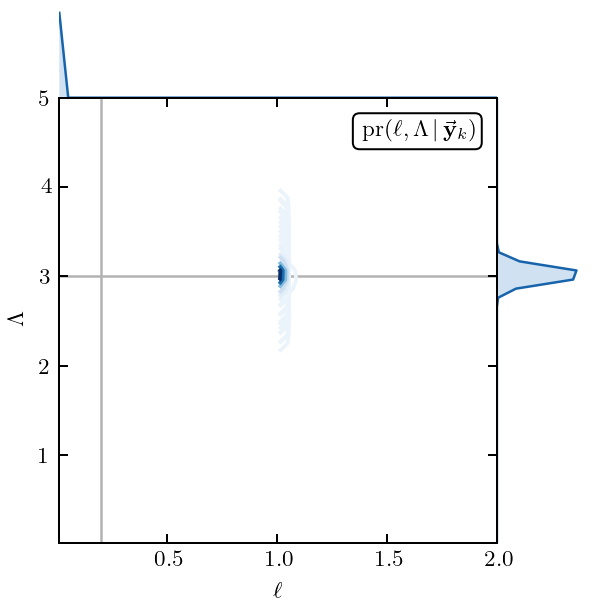

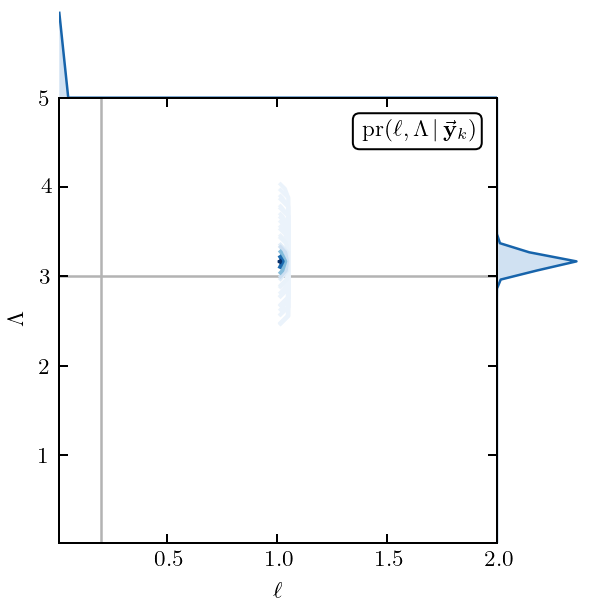

(3.1669387755102036,
 array([[3.06510204, 3.16693878],
        [2.96326531, 3.26877551]]))

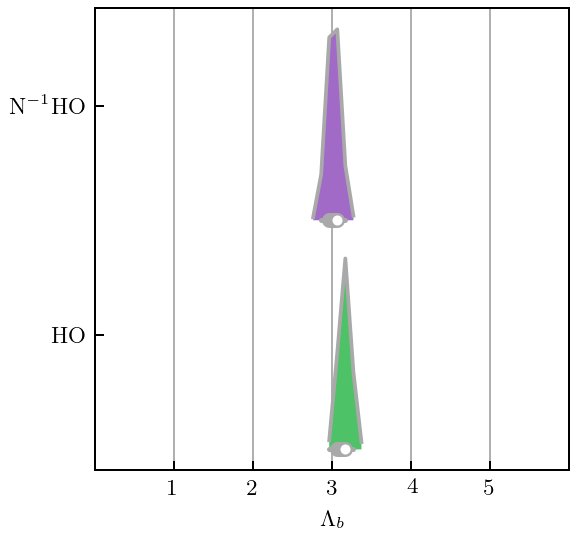

In [47]:
PlotLambdaPosteriorCorr(MyGP, np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]), 
        "sum", Lambda_b_true = Lambda_b_mygp, mpi_true = mpi_mygp)

data_Lb has shape (19, 10)
ref has shape (19,)
ref = [-26.13304044 -29.01969936 -30.18729561 -28.72048518 -24.25135384
 -17.23829793  -8.88755154  -0.74790762   5.81679052  10.01834932
  11.74163594  11.36127693   9.45329634   6.6165136    3.47754993
   0.76532485  -0.76954235  -0.67728002   0.81962436]
orders has shape(10,)
[0.18333333 0.2        0.21666667 0.23333333 0.25       0.26666667
 0.28333333 0.3        0.31666667 0.33333333 0.35       0.36666667
 0.38333333 0.4        0.41666667 0.43333333 0.45       0.46666667
 0.48333333]
RBF(length_scale=0.2) + WhiteKernel(noise_level=1e-10)
Main function call.
(2, 50, 49)
(2, 50, 49)
(2, 50, 49)
(2, 50, 49)
(2, 50, 49)
(2, 50, 49)
(2, 50, 49)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


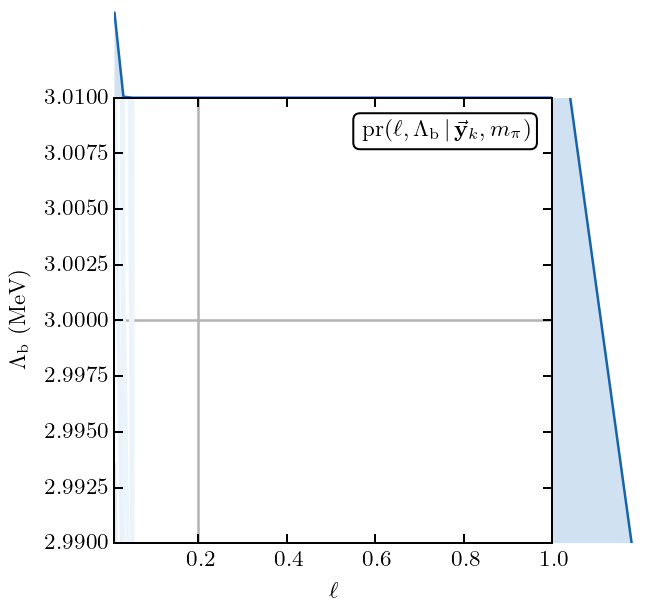

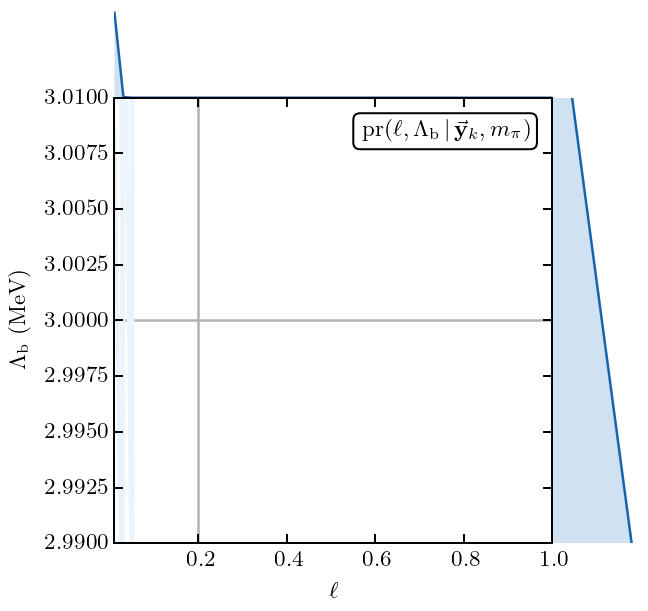

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


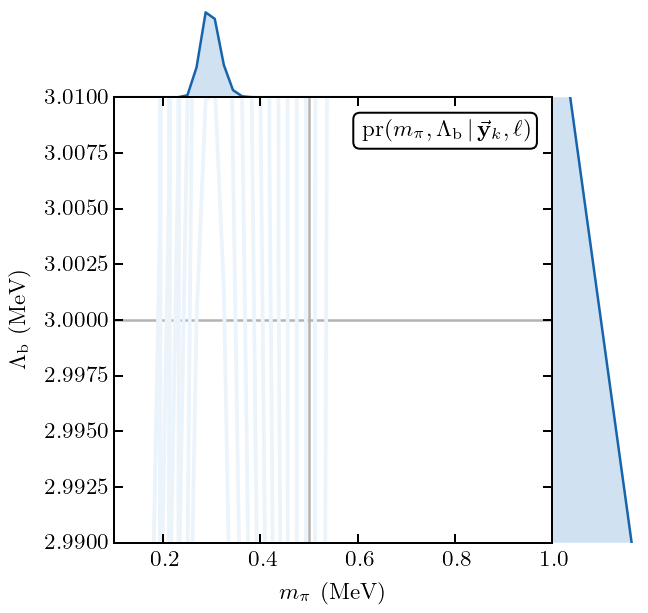

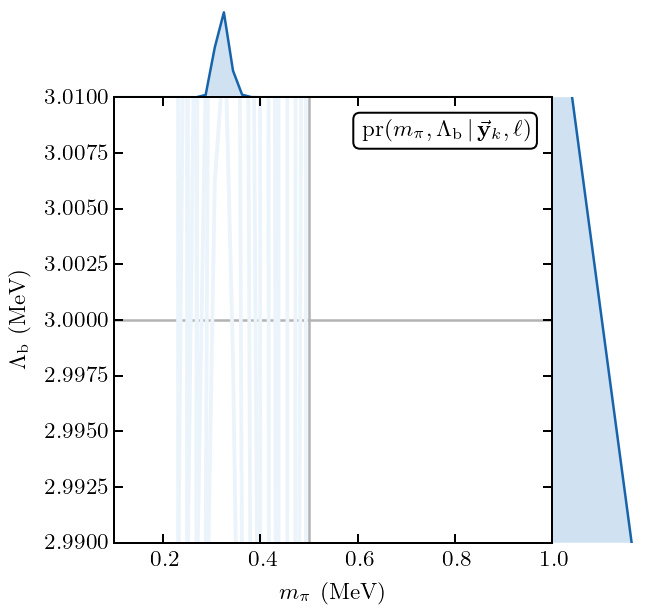

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


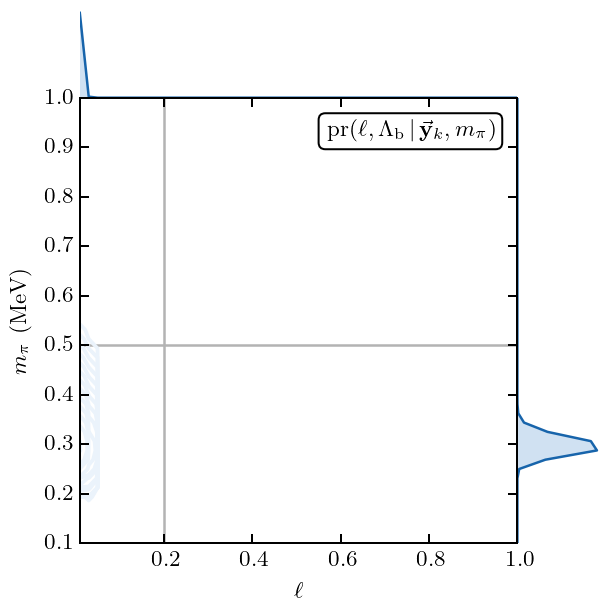

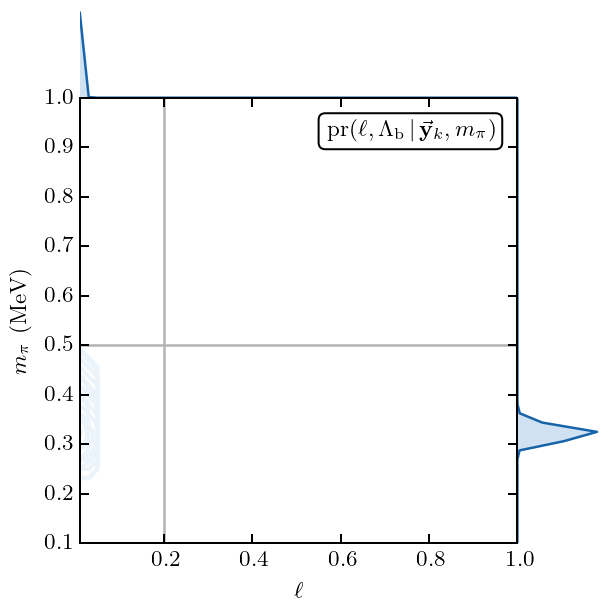

We should be plotting.


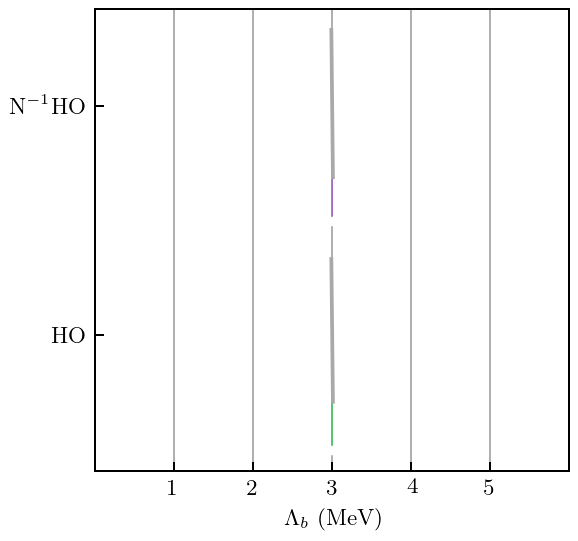

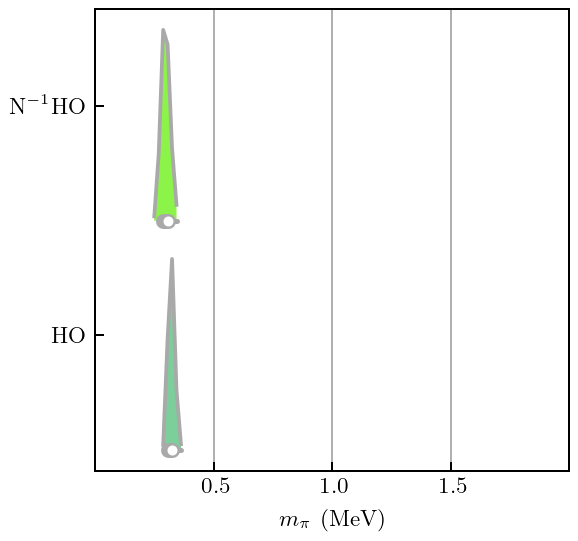

In [48]:
PlotLambdaMpiPosteriorCorr(MyGP, np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]), 
        "sum", Lambda_b_true = Lambda_b_mygp, mpi_true = mpi_mygp, 
        whether_plot_joint_Lbls = True, whether_plot_joint_Lbmpi = True, 
        whether_plot_joint_mpils = True, whether_plot_lambda = True, 
        whether_plot_mpi = True)

In [49]:
# PlotLambdaPosteriorCorr(MyGP, np.array([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]), "sum", Lambda_b_true = Lambda_b_mygp)

In [50]:
# PlotLambdaMpiPosteriorCorr(MyGP, np.array([0.14, 0.28, 0.43, 0.57, 0.72, 0.86]), "sum", Lambda_b_true = Lambda_b_mygp)

In [51]:
# PlotLambdaMpiPosteriorCorr(MyGP, np.array([0.25, 0.50, 0.75]), "sum", Lambda_b_true = Lambda_b_mygp)

data_Lb has shape (9, 10)
ref has shape (9,)
ref = [-29.01969936 -28.72048518 -17.23829793  -0.74790762  10.01834932
  11.36127693   6.6165136    0.76532485  -0.67728002]
orders has shape(10,)
[0.16666496 0.16650309 0.16485125 0.16088803 0.16666667 0.19272703
 0.227557   0.26307517 0.29785714]
RBF(length_scale=0.2) + WhiteKernel(noise_level=1e-10)
Main function call.
(2, 50, 49)
(2, 50, 49)
(2, 50, 49)
(2, 50, 49)
(2, 50, 49)
(2, 50, 49)
(2, 50, 49)


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


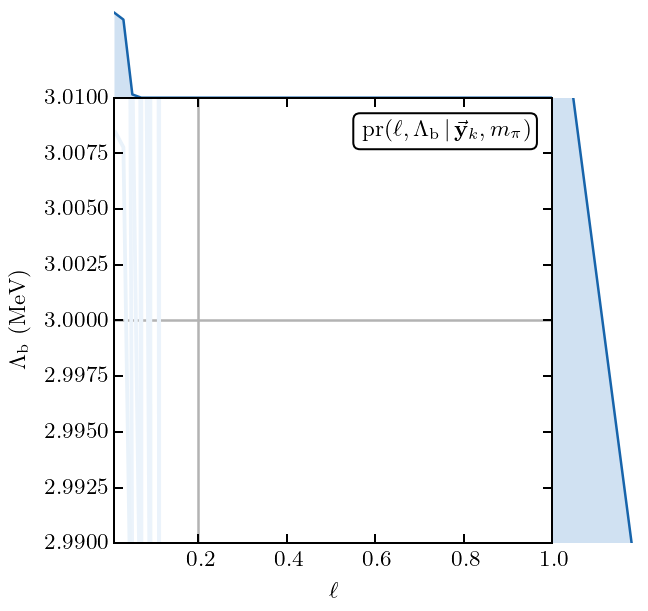

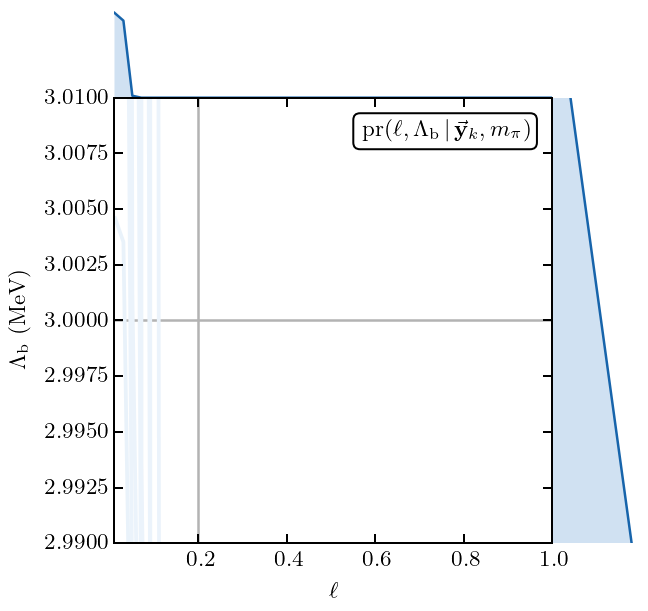

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


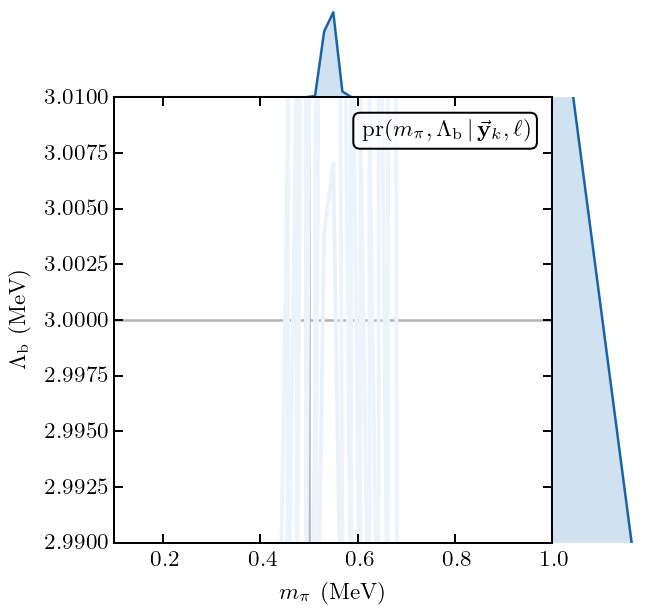

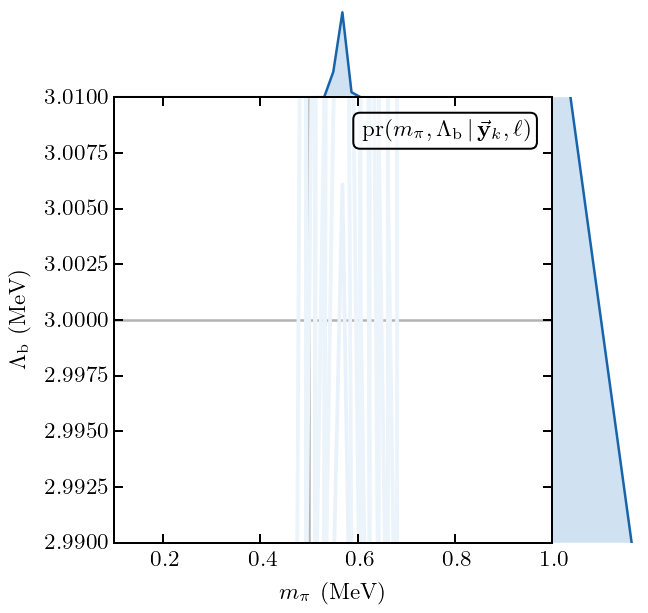

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


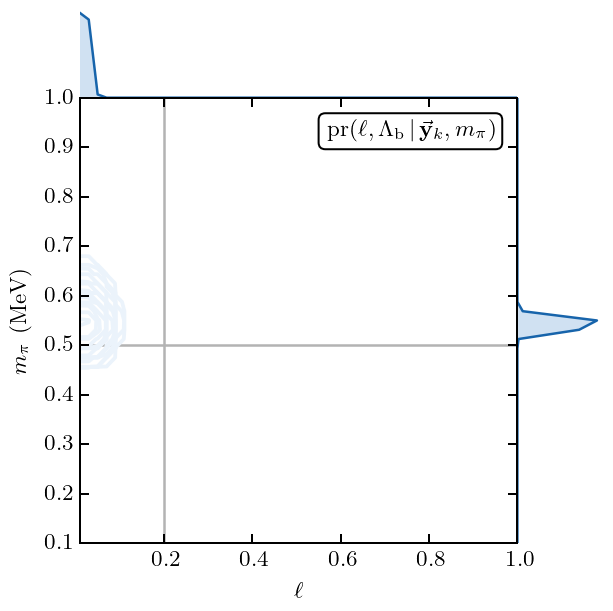

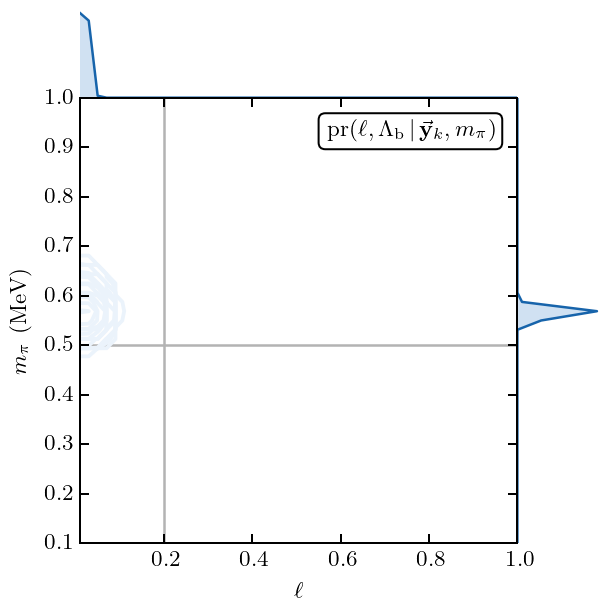

We should be plotting.


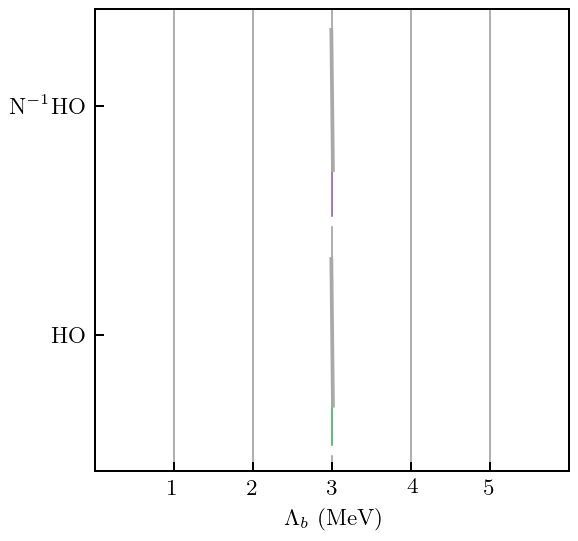

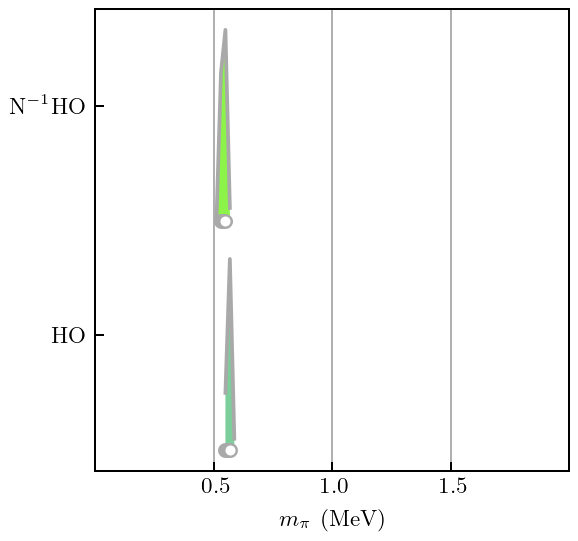

In [52]:
PlotLambdaMpiPosteriorCorr(MyGP, np.array([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]), 
            "poly", Lambda_b_true = Lambda_b_mygp, mpi_true = mpi_mygp)

In [53]:
# PlotLambdaMpiPosteriorCorr(MyGP, np.array([0.14, 0.28, 0.43, 0.57, 0.72, 0.86]), "poly", Lambda_b_true = Lambda_b_mygp)

In [54]:
# PlotLambdaMpiPosteriorCorr(MyGP, np.array([0.25, 0.50, 0.75]), "poly", Lambda_b_true = Lambda_b_mygp)

In [55]:
x = np.linspace(0, 1, 101).round(decimals = 2) # grid for x-values
x_power = 1 # polynomial scaling factor for x-axis

n_orders = 5    # Here we examine the case where we have info on some numer of non-trivial orders
final_order = 20  # We are going to treat some high order result as the final, converged answer

# creates the orders_info object
OrdersBig = order_info(n_orders, final_order)
orders_big = OrdersBig.orders_array
orders_all_big = OrdersBig.orders_all_array

# The true values of the hyperparameters for generating the EFT coefficients
ls = 0.2
sd_gp = 1.0
sd_fixed = None
center = 0
ref = 10
Q_param_mygp = "sum"
Lambda_b_mygp = 3
ratio = Q_approx(x, Q_param_mygp, Lambda_b_mygp)
nugget = 1e-10
df = 1
disp = 0
scale = 1.0
seed = 46
color_seed = 82
JordanHyper = GPHyperparameters(ls = ls, sd_gp = sd_gp, center = center, sd_fixed = sd_fixed, 
                                ref = ref, ratio = ratio, nugget = nugget, seed = seed, 
                                df = df, disp = disp, scale = scale)

# makes the GSUM object
MyGP = GSUMobj(JordanHyper, OrdersBig, x, x_power = x_power, color_seed = color_seed)
MyGP.PlotGPCurvesFit()

TypeError: Q_approx() missing 1 required positional argument: 'Lambda_b'

In [ ]:
# orders_loop = [i for i in range(3, n_orders + 1)]
orders_loop = [3, 4, 5, 6, 7]
testing_points = np.array([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90])

median_uncorr_list = np.array([])
median_corr_list = np.array([])
bounds_uncorr_list = np.array([])
bounds_corr_list = np.array([])

for ho, highest_order in enumerate(orders_loop):
    median_uncorr, bounds_uncorr = PlotLambdaPosteriorUncorr(MyGP, 
                            testing_points, 
                            Q_param_mygp, 
                            max_idx = highest_order)
    median_corr, bounds_corr = PlotLambdaPosteriorCorr(MyGP, 
                            testing_points, 
                            Q_param_mygp, 
                            max_idx = highest_order, 
                            Lambda_b_true = Lambda_b_mygp, 
                            whether_plot_joint = False)
    
#     median_uncorr_list.append(median_uncorr)
#     median_corr_list.append(median_corr)
#     bounds_uncorr_list.append(bounds_uncorr)
#     bounds_corr_list.append(bounds_corr)
    median_uncorr_list = np.append(median_uncorr_list, median_uncorr)
    median_corr_list = np.append(median_corr_list, median_corr)
    
    if ho == 0:
#         bounds_uncorr_list = np.append(bounds_uncorr_list, bounds_uncorr)
#         bounds_corr_list = np.append(bounds_corr_list, bounds_corr)
        bounds_uncorr_list = bounds_uncorr
        bounds_corr_list = bounds_corr
    else:
        bounds_uncorr_list = np.append(bounds_uncorr_list, bounds_uncorr, axis = 0)
        bounds_corr_list = np.append(bounds_corr_list, bounds_corr, axis = 0)

In [ ]:
print(median_uncorr_list)
print(bounds_uncorr_list)
print(median_corr_list)
print(bounds_corr_list)

bounds_uncorr_list = bounds_uncorr_list.reshape(len(orders_loop), 2, 2)
bounds_corr_list = bounds_corr_list.reshape(len(orders_loop), 2, 2)

print(median_uncorr_list)
print(bounds_uncorr_list)
print(median_corr_list)
print(bounds_corr_list)

bounds68_uncorr_list = abs(bounds_uncorr_list[:, 0, 0] - bounds_uncorr_list[:, 0, 1])
bounds68_corr_list = abs(bounds_corr_list[:, 0, 0] - bounds_corr_list[:, 0, 1])
bounds95_uncorr_list = abs(bounds_uncorr_list[:, 1, 0] - bounds_uncorr_list[:, 1, 1])
bounds95_corr_list = abs(bounds_corr_list[:, 1, 0] - bounds_corr_list[:, 1, 1])
print(np.shape(bounds68_uncorr_list))

fig_median, ax_median = plt.subplots(1, 1, figsize=(5, 5))
fig_bounds, ax_bounds = plt.subplots(1, 1, figsize=(5, 5))

ax_median.axhline(Lambda_b_mygp, linestyle = '--', color = 'gray', 
                  label = r'True $\Lambda_{b}$ value')
ax_median.scatter(orders_loop, median_uncorr_list, 
                 facecolor = 'orange', marker = 'o', 
                 label = 'Pointwise')
ax_median.errorbar(orders_loop, median_uncorr_list, yerr = bounds68_uncorr_list, 
                  ecolor = 'orange', ls = 'none', capsize = 6)
ax_median.scatter(orders_loop, median_corr_list, 
                 facecolor = 'blue', marker = 'o', 
                 label = 'Curvewise')
ax_median.errorbar(orders_loop, median_corr_list, yerr = bounds68_corr_list, 
                  ecolor = 'blue', ls = 'none', capsize = 6)
ax_median.set_xlim(min(orders_loop) - 1, max(orders_loop) + 1)
ax_median.set_xlabel("Maximum calculated order")
ax_median.set_ylim(0, 6)
ax_median.set_ylabel(r'$\Lambda_{b}$ estimate')
ax_median.set_title(r'$\Lambda_{b}$ posterior pdf median value (68\% error) vs. highest order'
                    + '\n' + fr'($Q = Q_{{{Q_param_mygp}}}$, $\ell = {ls}$, $N = {len(testing_points)}$)')
ax_median.legend()

ax_bounds.scatter(orders_loop, bounds68_uncorr_list,  
                 facecolor = 'orange', marker = '^', 
                 label = r'Pointwise (68\%)')
ax_bounds.scatter(orders_loop, bounds68_corr_list, 
                 facecolor = 'blue', marker = '^', 
                 label = r'Curvewise (68\%)')
ax_bounds.scatter(orders_loop, bounds95_uncorr_list, 
                 facecolor = 'orange', marker = 's', 
                 label = r'Pointwise (95\%)')
ax_bounds.scatter(orders_loop, bounds95_corr_list, 
                 facecolor = 'blue', marker = 's', 
                 label = r'Curvewise (95\%)')
ax_bounds.plot(orders_loop, (0.32 * np.array(orders_loop))**(-1.8), color = 'red')
ax_bounds.plot(orders_loop, (0.24 * np.array(orders_loop))**(-2.5), color = 'green')
ax_bounds.semilogx()
ax_bounds.set_xlim(min(orders_loop) - 1, max(orders_loop) + 1)
ax_bounds.set_xlabel("Maximum calculated order")
ax_bounds.semilogy()
# ax_bounds.set_ylim(0, 2)
ax_bounds.set_ylabel(r'$\Lambda_{b}$ distribution width')
# ax_bounds.set_title(fr'$\Lambda_{b}$ posterior pdf width vs. highest order')
ax_bounds.set_title(r'$\Lambda_{b}$ posterior pdf width vs. highest order'
                    + '\n' + fr'($Q = Q_{{{Q_param_mygp}}}$, $\ell = {ls}$, $N = {len(testing_points)}$)')
ax_bounds.legend()

plt.show()

In [ ]:
testing_points_list = [
    np.array([0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 0.28, 0.32, 0.36, 0.40, 0.44, 0.48, 0.52, 0.56, 0.60, 0.64, 0.68, 0.72, 0.76, 0.80, 0.84, 0.88, 0.92, 0.96]), 
    np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]), 
    np.array([0.07, 0.14, 0.21, 0.29, 0.36, 0.43, 0.50, 0.57, 0.64, 0.72, 0.79, 0.86, 0.93]), 
    np.array([0.08, 0.17, 0.25, 0.33, 0.42, 0.50, 0.58, 0.66, 0.75, 0.83, 0.91]), 
    np.array([0.09, 0.18, 0.27, 0.36, 0.45, 0.55, 0.64, 0.73, 0.82, 0.91]), 
    np.array([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]), 
    np.array([0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88]), 
    np.array([0.13, 0.25, 0.38, 0.50, 0.62, 0.74, 0.87]), 
    np.array([0.14, 0.28, 0.43, 0.57, 0.72, 0.86]), 
    np.array([0.17, 0.34, 0.51, 0.67, 0.85]), 
    np.array([0.20, 0.40, 0.60, 0.80]), 
    np.array([0.25, 0.50, 0.75])]
testing_points_lengths = [len(tp_array) for tp_array in testing_points_list]
lc_between_points = [ls / np.average(np.ediff1d(tp_array)) for tp_array in testing_points_list]
print(lc_between_points)

median_uncorr_list = np.array([])
median_corr_list = np.array([])
bounds_uncorr_list = np.array([])
bounds_corr_list = np.array([])

for tp, test_pts in enumerate(testing_points_list):
    median_uncorr, bounds_uncorr = PlotLambdaPosteriorUncorr(MyGP, 
                            test_pts, 
                            Q_param_mygp, 
                            max_idx = n_orders)
    median_corr, bounds_corr = PlotLambdaPosteriorCorr(MyGP, 
                            test_pts, 
                            Q_param_mygp, 
                            max_idx = n_orders, 
                            Lambda_b_true = Lambda_b_mygp, 
                            whether_plot_joint = False)
    
#     median_uncorr_list.append(median_uncorr)
#     median_corr_list.append(median_corr)
#     bounds_uncorr_list.append(bounds_uncorr)
#     bounds_corr_list.append(bounds_corr)
    median_uncorr_list = np.append(median_uncorr_list, median_uncorr)
    median_corr_list = np.append(median_corr_list, median_corr)
    
    if tp == 0:
#         bounds_uncorr_list = np.append(bounds_uncorr_list, bounds_uncorr)
#         bounds_corr_list = np.append(bounds_corr_list, bounds_corr)
        bounds_uncorr_list = bounds_uncorr
        bounds_corr_list = bounds_corr
    else:
        bounds_uncorr_list = np.append(bounds_uncorr_list, bounds_uncorr, axis = 0)
        bounds_corr_list = np.append(bounds_corr_list, bounds_corr, axis = 0)

In [ ]:
print(median_uncorr_list)
print(bounds_uncorr_list)
print(median_corr_list)
print(bounds_corr_list)

bounds_uncorr_list = bounds_uncorr_list.reshape(len(testing_points_lengths), 2, 2)
bounds_corr_list = bounds_corr_list.reshape(len(testing_points_lengths), 2, 2)

print(median_uncorr_list)
print(bounds_uncorr_list)
print(median_corr_list)
print(bounds_corr_list)

bounds68_uncorr_list = abs(bounds_uncorr_list[:, 0, 0] - bounds_uncorr_list[:, 0, 1])
bounds68_corr_list = abs(bounds_corr_list[:, 0, 0] - bounds_corr_list[:, 0, 1])
bounds95_uncorr_list = abs(bounds_uncorr_list[:, 1, 0] - bounds_uncorr_list[:, 1, 1])
bounds95_corr_list = abs(bounds_corr_list[:, 1, 0] - bounds_corr_list[:, 1, 1])
print(np.shape(bounds68_uncorr_list))

fig_median, [ax_median1, ax_median2] = plt.subplots(2, 1, figsize=(5, 10))
fig_bounds, [ax_bounds1, ax_bounds2] = plt.subplots(2, 1, figsize=(5, 10))

ax_median1.axhline(Lambda_b_mygp, linestyle = '--', color = 'gray')
ax_median1.scatter(testing_points_lengths, median_uncorr_list, 
                 facecolor = 'orange', marker = 'o', 
                 label = 'Pointwise')
ax_median1.errorbar(testing_points_lengths, median_uncorr_list, yerr = bounds68_uncorr_list, 
                  ecolor = 'orange', ls = 'none', capsize = 6)
ax_median1.scatter(testing_points_lengths, median_corr_list, 
                 facecolor = 'blue', marker = 'o', 
                 label = 'Curvewise')
ax_median1.errorbar(testing_points_lengths, median_corr_list, yerr = bounds68_corr_list, 
                  ecolor = 'blue', ls = 'none', capsize = 6)
ax_median1.set_xlim(min(testing_points_lengths) - 1, max(testing_points_lengths) + 1)
ax_median1.set_xlabel("Number of testing points")
ax_median1.set_ylim(0, 6)
ax_median1.set_ylabel(r'$\Lambda_{b}$ estimate')
ax_median1.set_title(r'$\Lambda_{b}$ posterior pdf median value (68\% error) vs. number of testing points'
                    + '\n' + fr'($Q = Q_{{{Q_param_mygp}}}$, $\ell = {ls}$, $\mathrm{{max order}} = {n_orders}$)')
ax_median1.legend()

ax_median2.axhline(Lambda_b_mygp, linestyle = '--', color = 'gray')
ax_median2.scatter(lc_between_points, median_uncorr_list, 
                 facecolor = 'orange', marker = 'o', 
                 label = 'Pointwise')
ax_median2.errorbar(lc_between_points, median_uncorr_list, yerr = bounds68_uncorr_list, 
                  ecolor = 'orange', ls = 'none', capsize = 6)
ax_median2.scatter(lc_between_points, median_corr_list, 
                 facecolor = 'blue', marker = 'o', 
                 label = 'Curvewise')
ax_median2.errorbar(lc_between_points, median_corr_list, yerr = bounds68_corr_list, 
                  ecolor = 'blue', ls = 'none', capsize = 6)
ax_median2.set_xlim(min(lc_between_points) - 1, max(lc_between_points) + 1)
ax_median2.set_xlabel("Number of testing points per correlation length")
ax_median2.set_ylim(0, 6)
ax_median2.set_ylabel(r'$\Lambda_{b}$ estimate')
ax_median2.set_title(r'$\Lambda_{b}$ posterior pdf median value (68\% error) \newline vs. number of testing points per correlation length'
                    + '\n' + fr'($Q = Q_{{{Q_param_mygp}}}$, $\ell = {ls}$, $\mathrm{{max order}} = {n_orders}$)')
ax_median2.legend()
fig_median.tight_layout()

ax_bounds1.scatter(testing_points_lengths, bounds68_uncorr_list,  
                 facecolor = 'orange', marker = '^', 
                 label = r'Pointwise (68\%)')
ax_bounds1.scatter(testing_points_lengths, bounds68_corr_list, 
                 facecolor = 'blue', marker = '^', 
                 label = r'Curvewise (68\%)')
ax_bounds1.scatter(testing_points_lengths, bounds95_uncorr_list, 
                 facecolor = 'orange', marker = 's', 
                 label = r'Pointwise (95\%)')
ax_bounds1.scatter(testing_points_lengths, bounds95_corr_list, 
                 facecolor = 'blue', marker = 's', 
                 label = r'Curvewise (95\%)')
ax_bounds1.plot(testing_points_lengths, (3.00 * np.array(testing_points_lengths))**(-0.5), color = 'red')
ax_bounds1.plot(testing_points_lengths, (3.00 * np.array(testing_points_lengths))**(-0.5), color = 'green')
ax_bounds1.semilogx()
ax_bounds1.set_xlim(min(testing_points_lengths) - 1, max(testing_points_lengths) + 1)
ax_bounds1.set_xlabel("Number of testing points")
ax_bounds1.semilogy()
# ax_bounds1.set_ylim(0, 2)
ax_bounds1.set_ylabel(r'$\Lambda_{b}$ distribution width')
# ax_bounds1.set_title(fr'$\Lambda_{b}$ posterior pdf width vs. highest order')
ax_bounds1.set_title(r'$\Lambda_{b}$ posterior pdf width vs. number of testing points'
                    + '\n' + fr'($Q = Q_{{{Q_param_mygp}}}$, $\ell = {ls}$, $\mathrm{{max order}} = {n_orders}$)')
ax_bounds1.legend()

ax_bounds2.scatter(lc_between_points, bounds68_uncorr_list,  
                 facecolor = 'orange', marker = '^', 
                 label = r'Pointwise (68\%)')
ax_bounds2.scatter(lc_between_points, bounds68_corr_list, 
                 facecolor = 'blue', marker = '^', 
                 label = r'Curvewise (68\%)')
ax_bounds2.scatter(lc_between_points, bounds95_uncorr_list, 
                 facecolor = 'orange', marker = 's', 
                 label = r'Pointwise (95\%)')
ax_bounds2.scatter(lc_between_points, bounds95_corr_list, 
                 facecolor = 'blue', marker = 's', 
                 label = r'Curvewise (95\%)')
ax_bounds2.plot(lc_between_points, (3.00 * np.array(lc_between_points))**(-0.5), color = 'red')
ax_bounds2.plot(lc_between_points, (3.00 * np.array(lc_between_points))**(-0.5), color = 'green')
ax_bounds2.semilogx()
ax_bounds2.set_xlim(max([min(lc_between_points) - 0.5, 0.1]), max(lc_between_points) + 1)
ax_bounds2.set_xticks([0.5, 1, 1.5, 2, 2.5])
ax_bounds2.set_xlabel("Number of testing points per correlation length")
ax_bounds2.semilogy()
# ax_bounds2.set_ylim(0, 2)
ax_bounds2.set_ylabel(r'$\Lambda_{b}$ distribution width')
# ax_bounds2.set_title(fr'$\Lambda_{b}$ posterior pdf width vs. highest order')
ax_bounds2.set_title(r'$\Lambda_{b}$ posterior pdf width \newline vs. number of testing points per correlation length'
                    + '\n' + fr'($Q = Q_{{{Q_param_mygp}}}$, $\ell = {ls}$, $\mathrm{{max order}} = {n_orders}$)')
ax_bounds2.legend()
fig_bounds.tight_layout()

plt.show()

In [ ]:
a = [1, 2, 3]
b = [1, 2, 3, 4]
c = [1, 2, 3, 4, 5]

Array = np.array([[[i + j + k for i in a] for j in b] for k in c])

print(np.shape(Array))